In [13]:
import random
from helpers import *
# random.seed(6)
# np.random.seed(6)
i=0
df = pd.read_csv('/home/guonaixin/trylab/factor-ident/simu_matrix/20Xfull'+str(i+1)+'.csv')
df =df.drop('Unnamed: 0',axis=1)
Z = np.array(df,dtype = 'float64')

# redefine Z to be all the other columns except the last one
n,p= Z.shape
Znorm = normalize_columns(Z)
mu0 = np.mean(Znorm, axis=0)
Sigma0 = np.cov(Znorm.T)
#Gamma0 = np.zeros((p, p))
Gamma0 =np.random.normal(0.0001,0.001,(p,p))
#find best sr
# St = sr_best(Znorm,lambda_val = 0.01, sigma = 500, T = 10000)
# print(St)
St=np.array([ 0, 4, 6, 9, 22])
Z0 = Z[:,St]
Gamma0[St] = np.linalg.inv(Z0.T@Z0)@Z0.T@Z

Gamma = cp.Variable((p,p))
Gamma.value = Gamma0
############ Sigma 1 ###################
Sigma = np.cov((Z-Z@Gamma.value).T)
############ Sigma 2 ###################
# Sigma = (Z-Z@Gamma0).T@(Z-Z@Gamma0)/n
############ Sigma 3 ###################
# k=5
# U, S, V =  np.linalg.svd(Z)
# Z_approx = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
# # Calculate the difference between the rank-k approximation and the actual values
# difference = Z - Z_approx
# Sigma = np.cov(np.transpose(difference), rowvar=True)  
# Sigma_inverse = np.linalg.inv(covariance_matrix) / 10**17

S,U=np.linalg.eig(Sigma)
Sigma_half_inv =U@np.diag(np.sqrt(1/S))@U.T/ 10**13

for i in range(1):
    objective = cp.Minimize(cp.norm( Sigma_half_inv @ Z.T - Sigma_half_inv @ Gamma.T @ Z.T  , 'fro')**2)
    # Define the constraint
    constraints = [
        cp.sum(cp.norm(Gamma, 2, axis=1))<=5
    ]
    # Define the optimization problem
    problem = cp.Problem(objective, constraints)
    # Solve the optimization problem
    result = problem.solve()

St0= chosen_set_with_press(Gamma.value,5,Znorm)[0]
print(np.linalg.norm(Gamma.value, axis=1))
print(St0,'sr',sr(np.linalg.solve(Sigma0[St0][:, St0], mu0[St0]), mu0[St0], Sigma0[St0][:, St0]) )


[8.74469887e-05 1.45996978e-05 2.33585915e-05 1.56420666e-05
 4.01194894e-05 5.61678507e-05 1.66474207e-05 7.15353929e-08
 1.61434127e-05 1.27314027e-04 8.16909296e-06 2.34963023e-05
 1.70911911e-05 1.32638001e-05 6.09953854e-06 1.55389300e-05
 2.05690640e-06 1.44902626e-05 7.71637947e-06 1.55911962e-05
 5.36333600e-06 1.10601985e-05 6.74591805e-05 1.06074225e-05
 5.29169198e-06]
[9, 0, 22, 5, 4] sr 0.10560294716641169


In [18]:

import numpy as np

import pandas as pd
import warnings

from helpers import *

warnings.filterwarnings('ignore')
fama285_ = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]
df22 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X22_22.csv')
dff22 = df22[df22.columns[1:]]
df99['Unnamed: 0'] = fama285_['Date']
df22['Unnamed: 0'] = fama285_['Date']

initial Index(['STR', 'REG', 'HMLM', 'PEAD', 'IVOL', 'QMJ', 'EPRD', 'IMD', 'Abr1',
       'DP', 'CLA', 'dROE1', 'MKTRF', 'IA', 'BAB', 'IAq1', 'SMB', 'CMA', 'OPA',
       'ISq1', 'dPIA', 'LIQ', 'NI', 'dFIN', 'COP', 'ILR1', 'CIM1', 'dLTI',
       'SIM1', 'FIN', 'ILE1', 'ISFF1', 'ME', 'HS', 'RER', 'OP', 'ETR', 'r1a',
       'IR', 'ETL'],
      dtype='object')
opt Index(['EPRD', 'ME', 'HMLM', 'REG', 'IVOL', 'PEAD'], dtype='object')
sr 0.4838745541756356


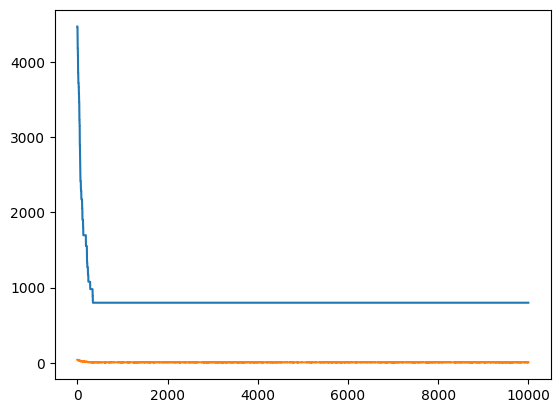

In [59]:
from helpers import  *
Z = dff99.values
Z = normalize_columns(Z)
T =10000
sigma =100
lambd =100
k = 9#or 9

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)   


# alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
# Sigma = np.cov((Z - Mh).T)
S,U=np.linalg.eig(Sigma)
S = np.abs(S)


Sigma_inv = np.linalg.inv(Sigma)
# Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:40]
print('initial', dff99.columns[indices])

St = set(indices)
Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
Theta = np.linalg.inv(Z_St.T @ Z_St) @ Z_St.T  @ Z 
SRwPenalty = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((p, T))


for t in range(T):
    j = np.random.randint(p)  # Generate a random index
    # Create new subset S_new by adding or removing j
    
    if j in St:
        S_new = St - {j}
    else:
        S_new = St | {j}
        
    Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
    Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new) @ Z_S_new.T  @ Z 

    # Calculate the new Theta and acceptance probability
   
    # acceptance_prob = np.exp(
    #     -sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
    #     - lambd * len(S_new)
    #     +sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
    #     + lambd * len(St)
    # )
    acceptance_prob = np.exp(
        -sigma * Theta_new[0]@ Sigma_inv @Theta_new[0].T
        -lambd * len(S_new)
        +sigma * Theta[0]@ Sigma_inv @Theta[0].T
        + lambd * len(St)
    )
    
    # Set the new subset S_t+1 with probability according to acceptance probability
    if np.random.rand() < acceptance_prob:
        St = S_new
        Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
        Theta = np.linalg.inv(Z_St.T @ Z_St) @ Z_St.T  @ Z 
    Sseq[list(S_new), t] = 1
    #record Sharpe ratio + penalty
    SRwPenalty[t] =  sigma * Theta[0] @ Sigma_inv @Theta[0].T + lambd * len(St)
    if SRwPenalty[t]<0:
        print(SRwPenalty[t], Theta[0] @ Sigma_inv @Theta[0].T )
import matplotlib.pyplot as plt
#Plots
plt.plot(SRwPenalty)
plt.plot(np.sum(Sseq, axis=0))    
sridx = np.argmin(SRwPenalty)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
print('opt',dff99.columns[Sopt])

mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))

    

initial Index(['STR', 'REG', 'HMLM', 'PEAD', 'IVOL', 'QMJ', 'EPRD', 'IMD', 'Abr1',
       'DP', 'CLA', 'dROE1', 'MKTRF', 'IA', 'BAB', 'IAq1', 'SMB', 'CMA', 'OPA',
       'ISq1', 'dPIA', 'LIQ', 'NI', 'dFIN', 'COP', 'ILR1', 'CIM1', 'dLTI',
       'SIM1', 'FIN', 'ILE1', 'ISFF1', 'ME', 'HS', 'RER', 'OP', 'ETR', 'r1a',
       'IR', 'ETL'],
      dtype='object')
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 72, 77, 78, 81, 83, 84, 85, 86, 87, 89, 90, 92, 94, 95, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 72, 77, 81, 83, 84, 85, 86, 87, 89, 90, 92, 94, 95, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 72, 77, 81, 83, 84, 85, 86, 87, 89, 90, 92, 94, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 70, 72, 77, 81, 83, 84, 85, 86, 87, 89, 90, 92, 94, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 

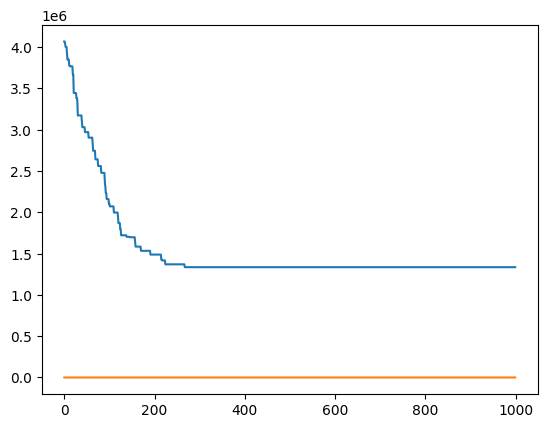

In [67]:
from helpers import  *
Z = dff99.values
Z = normalize_columns(Z)
T =1000
sigma = 0.6
lambd1 =40000
lambd2 =80000
k = 9 # or 9

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
alpha_hat = np.zeros(p)
e1 = np.eye(p+1)[0]
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)   


# alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
# Sigma = np.cov((Z - Mh).T)
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)
# Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:40]
print('initial', dff99.columns[indices])

St = set(indices)
Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
SRwPenalty = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((p, T))


for t in range(T):
    j = np.random.randint(p)  # Generate a random index
    # Create new subset S_new by adding or removing j
    
    if j in St:
        S_new = St - {j}
    else:
        S_new = St | {j}
        
    Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
    Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new+lambd1*e1@e1.T) @ Z_S_new.T  @ Z 

    # Calculate the new Theta and acceptance probability
   
    # acceptance_prob = np.exp(
    #     -sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
    #     - lambd * len(S_new)
    #     +sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
    #     + lambd * len(St)
    # )
    acceptance_prob = np.exp(-sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
        -lambd1 * Theta_new[0]@ Sigma_inv @Theta_new[0].T
        -lambd2 * len(S_new)
        +sigma * np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
        +lambd1 * Theta[0]@ Sigma_inv @Theta[0].T
        + lambd2 * len(St)
        
    )
    
    # Set the new subset S_t+1 with probability according to acceptance probability
    if np.random.rand() < acceptance_prob:
        St = S_new
        print(St)
        Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
        Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
    Sseq[list(S_new), t] = 1
    #record Sharpe ratio + penalty
    SRwPenalty[t] =  sigma * np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2+lambd1 * Theta[0]@ Sigma_inv @Theta[0].T + lambd2 * len(St)
   
import matplotlib.pyplot as plt
#Plots
plt.plot(SRwPenalty)
plt.plot(np.sum(Sseq, axis=0))    
sridx = np.argmin(SRwPenalty)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
print('opt',dff99.columns[Sopt])

mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))

    

opt Index(['COP', 'ME', 'SGq1', 'REG'], dtype='object')
sr 0.1825196567429313
objective 14489032.627822798
aSa 6286872.35736026
RSS 2202160.2704625363


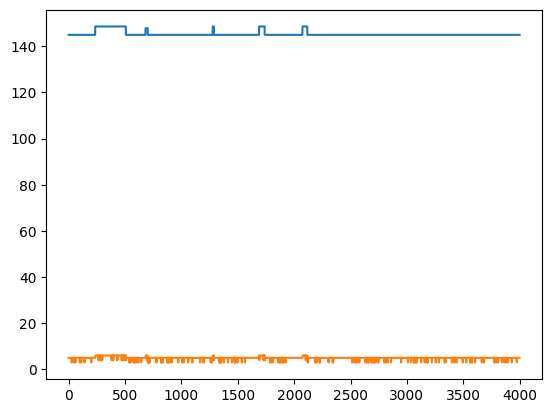

In [35]:
from helpers import  *
import numpy as np

import pandas as pd
import warnings


warnings.filterwarnings('ignore')
fama285_ = pd.read_csv('empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
df99 = pd.read_csv('empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)
T = 5000
sigma =0.00001
lambd1 =5/sigma
k = 12
lambd2 = 15/sigma

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
alpha_hat = np.zeros(p)
e1 = np.eye(p+1)[0]
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)   


# alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
# Sigma = np.cov((Z - Mh).T)
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)
# Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:30]
#print('initial', dff99.columns[indices])

St = set(indices)
Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
Objective = np.zeros(T)
aSa = np.zeros(T)
RSS = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((p, T))


for t in range(T):
    j = np.random.randint(p)  # Generate a random index
    # Create new subset S_new by adding or removing j
    
    if j in St:
        S_new = St - {j}
    else:
        S_new = St | {j}
        
    Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
    Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new+lambd1*e1@e1.T) @ Z_S_new.T  @ Z 

    # Calculate the new Theta and acceptance probability
   
    # acceptance_prob = np.exp(
    #     -sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
    #     - lambd * len(S_new)
    #     +sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
    #     + lambd * len(St)
    # )
    acceptance_prob = np.exp(sigma * (-np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
        -lambd1 * Theta_new[0]@ Sigma_inv @Theta_new[0].T
        -lambd2 * len(S_new)
        + np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
        +lambd1 * Theta[0]@ Sigma_inv @Theta[0].T
        + lambd2 * len(St)
    ))
    
    # Set the new subset S_t+1 with probability according to acceptance probability
    if np.random.rand() < acceptance_prob:
        St = S_new
        #print(St)
        Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
        Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
    Sseq[list(S_new), t] = 1
    #record Sharpe ratio + penalty
    Objective[t] =  np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2+lambd1 * Theta[0]@ Sigma_inv @Theta[0].T + lambd2 * len(St)
    aSa[t] = Theta[0]@ Sigma_inv @Theta[0].T
    RSS[t] = np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
import matplotlib.pyplot as plt
#Plots
plt.plot(Objective[1000:]/100000)
plt.plot(np.sum(Sseq[:,1000:], axis=0))    
sridx = np.argmin(Objective)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
print('opt',dff99.columns[Sopt])

mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))
print('objective', Objective[sridx])
print('aSa', lambd1*aSa[sridx])
print('RSS', RSS[sridx])

In [11]:
Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, list(Sopt)]),axis=1)    
Theta=np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z
np.sum(np.linalg.norm(Theta@Sigma_half_inv,axis=1))

5235.3514613311745

In [ ]:
Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, list(Sopt)]),axis=1)    
Theta=np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z
np.sum(np.linalg.norm(Theta,axis=1))

19.716747709665434

# Optimize Theta

In [152]:
############# Optimize Theta ################
from helpers import  *
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
fama285_ = pd.read_csv('empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)

n, p = Z.shape
svd_C =10
k = 9
lambd = 8/0.00001
# Define the optimization variable Gamma

alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)  
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)
Gamma = cp.Variable((p+1,p))
# Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, Sopt]),axis=1)
e1 = (np.eye(p+1)[0][:,np.newaxis])

# Theta = np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z 
# Gamma0 =np.zeros((p+1,p))
# Gamma0[0] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[0]
# Gamma0[Sopt] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[1:]
# Gamma.value = Gamma0
Z1 = np.concatenate((np.ones((n,1)),Z[:,:]),axis=1)

######################### OPT #####################################
Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
    
objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2
                                @Gamma@Sigma_half_inv, 'fro')**2 )
# Define the constraint
constraints = [
    cp.sum(cp.norm(Gamma[1:], 2, axis=1))<=svd_C
]
# Define the optimization problem
problem = cp.Problem(objective, constraints)
# Solve the optimization problem
result = problem.solve(solver=cp.SCS)



In [2]:

chosen_set=chosen_set_with_press((Gamma.value)[1:],6,Z)[0]
print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print('sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))

[88, 89, 90, 91, 92, 93] ['LTR' 'REG' 'IVOL' 'SUE' 'IA' 'ROE']
sr 0.31175882415678985


# try small set in X_s

In [4]:
############change small
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)

n, p = Z.shape
svd_C =2/0.001
k = 9
lambd = 2/0.001
# Define the optimization variable Gamma

alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)  
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)

# Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, Sopt]),axis=1)
# Theta = np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z 
# Gamma0 =np.zeros((p+1,p))
# Gamma0[0] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[0]
# Gamma0[Sopt] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[1:]
# Gamma.value = Gamma0
Sopt0 =[]
for i in ['ILR1', 'CMA', 'STR', 'REG', 'IVOL', 'PEAD','OCP', 'MKTRF', 'IA','BETA','CLA']:
    Sopt0.append(list(dff99.columns).index(i))
Sopt0+=[0,1,2,3,4,5,6,7,8,9,10]
Sopt = Sopt0
Z1 = np.concatenate((np.ones((n,1)),Z[:,Sopt]),axis=1)
e1 = (np.eye(len(Sopt)+1)[0][:,np.newaxis])
Gamma = cp.Variable((len(Sopt)+1,p))
######################### OPT #####################################
Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
    
objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2
                                @Gamma@Sigma_half_inv, 'fro')**2 )
# Define the constraint
constraints = [
    cp.sum(cp.norm(Gamma[1:], 2, axis=1))<=svd_C
]
# Define the optimization problem
problem = cp.Problem(objective, constraints)
# Solve the optimization problem
result = problem.solve(solver=cp.MOSEK, warm_start = True)


In [5]:
# chosen_set=chosen_set_with_press((B.value @ Sigma_half_inv)[1:],6,Z)[0]
chosen_set=chosen_set_with_press((Gamma.value)[1:],6,Z[:,Sopt])[0]
print(chosen_set,np.array(dff99.columns)[np.array(Sopt)[chosen_set]])

mu = np.mean(Z[:,Sopt], axis=0)
Sigma = np.cov(Z[:,Sopt].T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print('sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))

[7, 17, 16, 4, 1, 8] ['MKTRF' 'COP' 'CLA' 'IVOL' 'CMA' 'IA']
sr 0.169846323609881


# Optimize B



In [ ]:
from helpers import  *
import numpy as np
import pandas as pd
import warnings
from itertools import combinations

df99= pd.read_csv('/home/guonaixin/trylab/factor-ident/simu_matrix/600_100_5Xfull_sr2.csv')
dff99 = df99[df99.columns[1:]]
Z = dff99.values
Z = normalize_columns(Z)
srsr = 0
mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
for chosen_set in combinations(list(range(100)), 5):
    chosen_set = list(chosen_set)
    wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
    if sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]) >srsr:
        srsr = sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set])
        print(chosen_set)



In [21]:
#B
from helpers import  *
import numpy as np
import pandas as pd
import warnings
from itertools import combinations
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')

dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)

n, p = Z.shape
svd_C=100

k = 9
lambd = 2/0.00001
# Define the optimization variable Gamma

alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)  
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half = U@np.diag(np.sqrt(S))@U.T
Sigma_half_inv =np.linalg.inv(Sigma_half)

Gamma = cp.Variable((p+1,p))
# Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, Sopt]),axis=1)
# e1 = (np.eye(len(Sopt)+1)[0][:,np.newaxis])
# Theta = np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z 
# Gamma0 = np.zeros((p+1,p))
# Gamma0[0] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[0]
# Gamma0[Sopt] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[1:]
# Gamma.value = Gamma0
B = cp.Variable((p+1,p))
# B.value =  Gamma0 @ Sigma_half
Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
######################### OPT #####################################
Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
e1 = (np.eye(p+1)[0][:,np.newaxis])
Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
    
objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2
                                @ B, 'fro')**2 )
# Define the constraint
# constraints = [
#     cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C
# ]

constraints = [
    cp.sum(cp.norm((B )[1:] , 2, axis=1))<=svd_C
]
# Define the optimization problem
problem = cp.Problem(objective, constraints)
# Solve the optimization problem
result = problem.solve(solver=cp.SCS)


In [22]:
#B
chosen_set=chosen_set_with_press((B.value @ Sigma_half)[1:],6,Z)[0]
print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print('sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))

[98, 27, 12, 11, 81, 83] ['FIN' 'EBP' 'dCOA' 'dBE' 'CMA' 'HMLM']
sr 0.04449141096285333


In [20]:
np.round(np.linalg.norm(B.value,axis=1),3)

array([2.7600e-01, 0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03,
       2.0000e-03, 0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03,
       0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03, 0.0000e+00,
       0.0000e+00, 1.0000e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03, 0.0000e+00,
       0.0000e+00, 1.0000e-03, 0.0000e+00, 4.1800e+01, 1.0000e-03,
       1.0000e-03, 1.0000e-03, 1.0000e-03, 0.0000e+00, 0.0000e+00,
       1.0000e-03, 1.0000e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e-03, 1.0000e-03, 0.0000e+00, 1.0000e-03,
       0.0000e+00, 1.0000e-03, 4.2700e-01, 2.0000e-03, 1.0000e-03,
       0.0000e+00, 0.0000e+00, 2.0000e-03, 2.0000e-03, 0.0000e+00,
       1.0000e-03, 1.0000e-03, 1.0000e-03, 2.0000e-03, 1.0000e-03,
       1.0000e-03, 2.0000e-03, 2.0000e-03, 0.0000e+00, 1.0000e-03,
       1.0000e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-03,
       2.0000e-03, 0.0000e+00, 1.0000e-03, 0.0000e+00, 1.0000e

In [7]:
(B.value@Sigma_half_inv[0])

array([ 2.23256213e-01,  1.35361487e+03,  7.69195439e+01,  1.18500521e+02,
       -7.10294520e+02,  1.75347153e+02,  3.55892097e+02,  6.47892088e+02,
        9.18735987e+02, -8.42811750e+02, -2.46435499e+01,  1.39868441e+02,
       -2.11002290e+02, -2.67876885e+02,  5.30549992e+01, -5.06490517e+01,
        1.40762066e+01, -8.93604474e+01, -7.97367705e+01, -2.05868910e+02,
       -1.21366751e+02, -1.43353492e+01, -1.42894376e+02, -1.34167581e+02,
        5.95766320e+02,  6.51484389e+02, -5.67240619e+02,  1.02964762e+02,
       -9.75891471e+02, -5.02749384e+02, -6.01672529e+02,  9.27167884e+02,
        8.55241073e+01,  3.40720810e+01,  2.57571954e+02,  1.18553102e+02,
       -4.81048093e+02,  1.72794777e+01,  5.92401642e+02,  4.38129178e+02,
        7.17111928e+02,  3.10803336e+02, -8.51436943e+02,  1.49013051e+02,
        2.60814863e+01,  6.46939280e+01,  5.75904425e+01,  5.56501587e+02,
       -4.24207215e+02, -6.79480602e+01,  8.09694003e+02,  2.60101370e+02,
       -1.27236569e+02,  

In [104]:
# Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, Sopt]),axis=1)
# Gamma0 =np.zeros((p+1,p))
# Gamma0[0] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[0]
# Gamma0[Sopt] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[1:]
# Gamma0

In [ ]:
## m-h & grouplasso

from helpers import  *
import numpy as np

import pandas as pd
import warnings


warnings.filterwarnings('ignore')
fama285_ = pd.read_csv('empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
df99 = pd.read_csv('empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)
T = 5000
sigma =0.0001
lambd1 =2/sigma
k = 9
lambd2 = 5/sigma

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
for _ in range(300):
    alpha_hat = np.zeros(p)
    e1 = np.eye(p+1)[0]
    Z_hat = np.zeros_like(Z)
    for i in range(p):
        Z_minus_i = np.delete(Z, i, axis=1)
        Ui,Si,Vi = np.linalg.svd(Z_minus_i)
        X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
        beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
        alpha_hat[i]=beta[0]
        Z_hat[:, i] = np.dot(X, beta)
    Sigma = np.cov(Z - Z_hat, rowvar=False)   


    # alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
    # Sigma = np.cov((Z - Mh).T)
    S,U=np.linalg.eig(Sigma)
    S = np.abs(S)
    Sigma_inv = np.linalg.inv(Sigma)
    Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)
    # Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
    indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:30]
    #print('initial', dff99.columns[indices])

    St = set(indices)
    Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
    Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
    e1_t = (np.eye(len(St)+1)[0][:,np.newaxis])
    Opt_matrix2_t= np.concatenate((Z_St, np.sqrt(lambd1)*e1_t.T),axis=0)
        
    Objective = np.zeros(T)
    aSa = np.zeros(T)
    RSS = np.zeros(T)
    #record the subset selection in each MH update
    Sseq = np.zeros((p, T))


    for t in range(T):
        j = np.random.randint(p)  # Generate a random index
        # Create new subset S_new by adding or removing j
        
        if j in St:
            S_new = St - {j}
        else:
            S_new = St | {j}
            
        Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
        Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new+lambd1*e1@e1.T) @ Z_S_new.T  @ Z 

        # Calculate the new Theta and acceptance probability
        
        # B.value =  Gamma0 @ Sigma_half
    
        ######################### OPT #####################################
        Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
        e1_new = (np.eye(len(S_new)+1)[0][:,np.newaxis])
        Opt_matrix2_new = np.concatenate((Z_S_new, np.sqrt(lambd1)*e1_new.T),axis=0)
        
        acceptance_prob = np.exp(sigma * (-np.linalg.norm(Opt_matrix1  - (Opt_matrix2_new @  Theta_new @ Sigma_half_inv), 'fro')**2
            -lambd2 *  np.sum(np.linalg.norm((Theta_new)[1:], 2, axis=1))

            + np.linalg.norm(Opt_matrix1  - (Opt_matrix2_t @  Theta @ Sigma_half_inv), 'fro')**2
            + lambd2 *  np.sum(np.linalg.norm((Theta)[1:], 2, axis=1))
        ))
        
        # Set the new subset S_t+1 with probability according to acceptance probability
        if np.random.rand() < acceptance_prob:
            St = S_new
            #print(St)
            Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
            Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
            e1_t = (np.eye(len(St)+1)[0][:,np.newaxis])
            Opt_matrix2_t= np.concatenate((Z_St, np.sqrt(lambd1)*e1_t.T),axis=0)
        
        Sseq[list(S_new), t] = 1
        #record Sharpe ratio + penalty
        Objective[t] = np.linalg.norm(Opt_matrix1  - (Opt_matrix2_t @  Theta @ Sigma_half_inv), 'fro')**2  + lambd2 *  np.sum(np.linalg.norm((Theta)[1:], 2, axis=1))
        aSa[t] = Theta[0]@ Sigma_inv @Theta[0].T
        RSS[t] = np.linalg.norm(Opt_matrix1  - (Opt_matrix2_t @  Theta @ Sigma_half_inv), 'fro')**2
    import matplotlib.pyplot as plt
    print(len(Sopt))
    #Plots
    # plt.plot(Objective[1000:]/80000)
    # plt.plot(np.sum(Sseq[:,1000:], axis=0))    
    sridx = np.argmin(Objective)
    #Find the indices of selected factors
    Sopt = np.where(Sseq[:, sridx])[0]
    if len(Sopt)==6:
        print('opt',dff99.columns[Sopt])

        mu = np.mean(Z, axis=0)
        Sigma = np.cov(Z.T)
        wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
        print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))
        print('objective', Objective[sridx])
        print('aSa', lambd1*aSa[sridx])
        print('RSS', RSS[sridx])


# simulation

In [ ]:

from helpers import *

# df99 = pd.read_csv('empirical_data/X99_22.csv')


# k = 8
thousand =1
lambd = 2*thousand #control alpha
# lambd2 = 450000 #control sparisty
par=0
Lambd2 = [2.6*thousand]
K =[5]
# Define the optimization variable Gamma
for i in range(100):
    df99= pd.read_csv('/home/guonaixin/trylab/factor-ident/simu_matrix/600_100_5Xfull'+str(i+1)+'.csv')
    dff99 = df99[df99.columns[1:]]
    Z = dff99.values
    Z = normalize_columns(Z)

    n, p = Z.shape
    for lambd2 in Lambd2:
        for k in K:
            alpha_hat = np.zeros(p)
            alpha_z = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            Z_z = np.zeros_like(Z)
            for i in range(p):
                
                # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                Z_minus_i = np.delete(Z, i, axis=1) 
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
                # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
                # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
                #                      )
            
            
            Sigma = np.cov(Z - Z_hat, rowvar=False)
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)
            
            # Sigma_z =  np.cov(Z - Z_z, rowvar=False)
            # S,U=np.linalg.eig(Sigma_z)
            # #S = np.abs(S)

            # alpha_z_score = 1/ np.diagonal(Sigma_half)
            # alpha_z_score = np.abs(np.mean(Z,axis=0))/np.std(Z,axis=0)
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
            B = cp.Variable((p,p))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
            Opt_matrix1 = Z
            # Opt_matrix1 = np.concatenate((Z, np.zeros((1,p))),axis=0)
            # Opt_matrix1 = normalize_columns(Opt_matrix1 )
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            # Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
            Opt_matrix2 = Z  
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B) , 2, axis=1)))
            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            # objective = cp.Minimize(cp.norm((Z- Z1@ B)@Sigma_half_inv, 'fro')**2 +lambd*cp.norm(e1.T@B@Sigma_half_inv, 'fro')**2+lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            # nonzero = np.count_nonzero(np.round(row_norms[1:],6))
            # chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
            nonzero = np.count_nonzero(np.round(row_norms,6))
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
           
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value ), 2, axis=1)))
           
            print('deleting p52w6')
            B.value[62]=np.zeros(p)
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value ), 2, axis=1)))
           
        
         

# Try

[83 89 61 87 78 80 55  2 97 77 96 84 94 73 85 93  9 75] ['HMLM' 'REG' 'P52W6' 'STR' 'SMB' 'RMW' 'OCP' 'ATO' 'PEAD' 'MKTRF' 'BETA'
 'QMJ' 'IMD' 'SP' 'BAB' 'ROE' 'CTO' 'TV1']
0.05 2 3 sr 0.5812899198093833 18
49.456289665671434 12.267744413195043
2226.813006525349
[83 89 61 87 78 80  2 55 97 77 96 84 94 73 85 93  9] ['HMLM' 'REG' 'P52W6' 'STR' 'SMB' 'RMW' 'ATO' 'OCP' 'PEAD' 'MKTRF' 'BETA'
 'QMJ' 'IMD' 'SP' 'BAB' 'ROE' 'CTO']
0.05826377295492488 2 3 sr 0.5760649978550302 17
50.651851752293055 13.003767232259083
2395.6429159292234
[83 89 61 87 80 78  2 77 55 97 96 84 94 73 85 93] ['HMLM' 'REG' 'P52W6' 'STR' 'RMW' 'SMB' 'ATO' 'MKTRF' 'OCP' 'PEAD' 'BETA'
 'QMJ' 'IMD' 'SP' 'BAB' 'ROE']
0.06652754590984974 2 3 sr 0.5730331401012438 16
51.81602554953761 13.604066429089992
2387.959320086524
[83 89 61 87 80 78  2 77 96 97 55 84 94 85 73 93] ['HMLM' 'REG' 'P52W6' 'STR' 'RMW' 'SMB' 'ATO' 'MKTRF' 'BETA' 'PEAD' 'OCP'
 'QMJ' 'IMD' 'BAB' 'SP' 'ROE']
0.07479131886477462 2 3 sr 0.5730331401012441 16
52.9

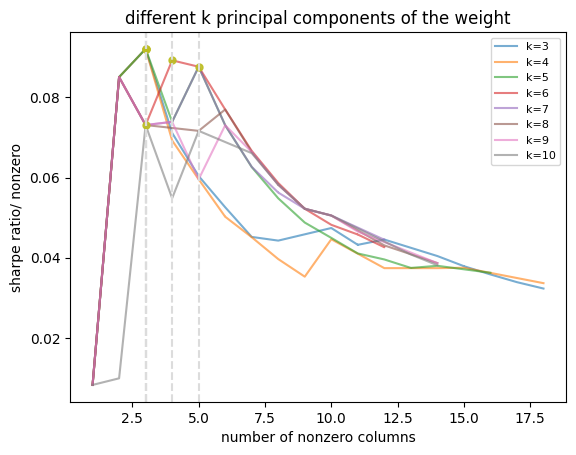

In [6]:
from helpers import *

df99 = pd.read_csv('empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values


# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)
n, p = Z.shape

# k = 8
thousand =1
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty
PAR = [2]
# Lambd2 = [60*thousand,150*thousand,180*thousand]
# K =[12,25,30,70]
Lambd2 = np.linspace(0.05*thousand, 5*thousand, 600)
K =[3,4,5,6,7,8,9,10]
ymaxpointlist=[]
maxpointlist=[]
# Define the optimization variable Gamma'
for k in K:
    srlist=[]
    nonzerolist=[]
    
    for par in PAR:
        for lambd2 in Lambd2:
            alpha_hat = np.zeros(p)
            alpha_z = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            Z_z = np.zeros_like(Z)
            for i in range(p):
                
                # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                Z_minus_i = np.delete(Z, i, axis=1) 
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
                # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
                # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
                #                      )
            
            
            Sigma = np.cov(Z - Z_hat, rowvar=False)
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)
            
            # Sigma_z =  np.cov(Z - Z_z, rowvar=False)
            # S,U=np.linalg.eig(Sigma_z)
            # #S = np.abs(S)

            # alpha_z_score = 1/ np.diagonal(Sigma_half)
            # alpha_z_score = np.abs(np.mean(Z,axis=0))/np.std(Z,axis=0)
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
            B = cp.Variable((p,p))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
            Opt_matrix1 = Z
            # Opt_matrix1 = np.concatenate((Z, np.zeros((1,p))),axis=0)
            # Opt_matrix1 = normalize_columns(Opt_matrix1 )
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            # Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
            Opt_matrix2 = Z  
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B) , 2, axis=1)))
            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            # objective = cp.Minimize(cp.norm((Z- Z1@ B)@Sigma_half_inv, 'fro')**2 +lambd*cp.norm(e1.T@B@Sigma_half_inv, 'fro')**2+lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            # nonzero = np.count_nonzero(np.round(row_norms[1:],6))
            # chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
            nonzero = np.count_nonzero(np.round(row_norms,6))
            
            if nonzero==1:
                chosen_set = np.argsort(row_norms)[::-1][:nonzero]
                print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
                mu = np.mean(Z, axis=0)
                Sigma = np.cov(Z.T)
                wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
                srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
                nonzerolist.append(nonzero)
                break
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
           
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value ), 2, axis=1)))
            
            
            srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
            nonzerolist.append(nonzero)
            
            union_set = chosen_set
            check_set = np.setdiff1d(range(p),union_set)
            check_press1 =np.mean([PRESS_statistic((Z@Sigma_half_inv)[:,i],Z[:,chosen_set]) for i in check_set])
            print( check_press1)
    maxpoint= list(np.array(srlist)/np.array(nonzerolist)).index(np.max(np.array(srlist)/np.array(nonzerolist)))
    maxpointlist.append(np.array(nonzerolist)[maxpoint])
    ymaxpointlist.append(np.max(np.array(srlist)/np.array(nonzerolist)))
    plt.plot(np.array(nonzerolist),np.array(srlist)/np.array(nonzerolist),"-", markersize=5, alpha = 0.6)
Maxpointlist =[]   
Ymaxpointlist=[]
for i in range(len(maxpointlist)):
    if maxpointlist[i]>2:
        Maxpointlist.append(maxpointlist[i])
        Ymaxpointlist.append(ymaxpointlist[i])
plt.plot(Maxpointlist,Ymaxpointlist,"o", markersize=5, alpha = 0.9)
plt.title('different k principal components of the weight')
plt.xlabel('number of nonzero columns')
plt.ylabel('sharpe ratio/ nonzero') 
plt.legend(['k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8','k=9','k=10'],prop = {'size':8},loc=1)      
for i in Maxpointlist:
    plt.axvline(x=i, ymin=0, ymax=1, color='gainsboro', linestyle='--')  
plt.show()

In [ ]:
[83 84 89 87 77] ['HMLM' 'QMJ' 'REG' 'STR' 'MKTRF']
13000.0 2 12 sr 0.3077526348016145 5
1671951.9379776872 359128286.1560471
deleting p52w6
1671951.9380741604 359128286.11884457

In [30]:
np.count_nonzero(np.round( np.linalg.norm((B.value@Sigma_half), axis=1) [1:],6))

5

In [20]:
np.array(dff99.columns)[np.argsort(1/alpha_z_score)]

array(['HMLM', 'STR', 'REG', 'PEAD', 'IMD', 'MKTRF', 'EPRD', 'P52W6',
       'dROE1', 'Abr1', 'QMJ', 'BAB', 'IA', 'CMA', 'CLA', 'IAq1', 'DP',
       'EP', 'ISq1', 'BETA', 'LIQ', 'OL', 'SMB', 'dLNO', 'NI', 'UMD',
       'dNOA', 'dLTI', 'IM1', 'OPA', 'IVOL', 'NEI1', 'CP', 'dNCO', 'VHP',
       'COP', 'ROE', 'ROA1', 'ILE1', 'dPIA', 'FIN', 'DAC', 'r1a', 'OPE',
       'Dur', 'dNCA', 'dII', 'HS', 'dCOA', 'OP', 'ETR', 'CTO', 'ISFF1',
       'POA', 'SUE', 'EM', 'dROA1', 'IVG', 'PDA', 'RER', 'CIM1', 'IOCA',
       'RS1', 'ETL', 'NDF', 'IG', 'IR', 'NOP', 'SIM1', 'SGq1', 'ME', 'SP',
       'RMW', 'dFNL', 'ILR1', 'HML', 'NOA', 'PTA', 'EBP', 'OA', 'ACI',
       'OLEq1', 'OCA', 'OCP', 'GPA', 'IVq1', 'ROE1', 'LTR', 'dBE', 'TV1',
       'BM', 'CEI', 'Resid111', 'dFIN', 'NXF', 'ATO', 'dWC', 'IVC', 'TA'],
      dtype=object)

In [2]:
1/alpha_z_score**par

array([  4.87003456,  29.18862023, 102.68276966,  48.18658494,
        53.05882121,  15.69471041,   5.97434959,   9.62483347,
         9.18710153,  14.07419707,  10.94163842,  38.24863999,
        13.22861104,  77.9424467 ,  23.28037762,  12.57839403,
         8.4199426 ,   8.9564498 ,  12.1832928 ,   9.21315661,
         8.7312887 ,   6.39796204,  10.66081957,  14.72050196,
         4.74262232,  12.03482694, 194.9982635 ,  28.21403095,
        14.40598272,   6.89148397,   4.13284048,  16.73803745,
        13.68458464,  31.93425783,  13.12303076,   6.05051615,
        17.49278063,  10.25270374,  23.43398122,   8.95651396,
        16.64334055,  17.57056207,  14.34577464,   6.9895667 ,
       206.63998817,  14.73779531,  33.82858181,  21.21992118,
        17.1445199 ,   9.13743584,  26.34507839,  19.75950605,
        88.66666348,  28.75636516,  30.80852103,  31.47108355,
         8.01263105,  30.06694358,  13.52179924,   8.99781535,
        11.76228099,   4.14899143,  14.88032375,  14.35

In [3]:
np.sort(np.diag(Sigma_half_diag))[::-1]

array([0.03846814, 0.03749299, 0.03724788, 0.03559408, 0.03526304,
       0.03508108, 0.03458782, 0.03424985, 0.03357479, 0.03352881,
       0.03330504, 0.03271352, 0.03110334, 0.03092864, 0.03066565,
       0.03063181, 0.03021776, 0.03015975, 0.02967188, 0.02966207,
       0.02910865, 0.02909334, 0.02854346, 0.028117  , 0.02802187,
       0.02792217, 0.02784358, 0.02761206, 0.02733019, 0.02700243,
       0.02665567, 0.02652415, 0.02608797, 0.02594728, 0.02562549,
       0.02559775, 0.02514398, 0.02504038, 0.02478927, 0.02476649,
       0.02475026, 0.02471763, 0.02432237, 0.02427952, 0.02427412,
       0.02393443, 0.02377444, 0.02365327, 0.02349288, 0.02329386,
       0.02326481, 0.02323193, 0.02290374, 0.02290366, 0.02285603,
       0.02267777, 0.02258625, 0.02202901, 0.02168398, 0.02157139,
       0.02110308, 0.02081938, 0.02078425, 0.02060008, 0.02041823,
       0.02023904, 0.019894  , 0.01967426, 0.01946504, 0.01928889,
       0.01829994, 0.01813777, 0.01811911, 0.01774425, 0.01752

In [29]:
from helpers import *

df99 = pd.read_csv('empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values[:36*12]
Z = normalize_columns(Z)
np.sum(np.linalg.svd(Z)[1][:6])/np.sum(np.linalg.svd(Z)[1])

0.24756710673376384

In [35]:

from helpers import  *
import numpy as np

import pandas as pd
import warnings


# df99 = pd.read_csv('empirical_data/X99_22.csv')
# dff99 = df99[df99.columns[1:]]

# Z = dff99.values

par=0.8
# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)
n, p = Z.shape

# k = 8
thousand =1
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty


for k in range(3,30):
    alpha_hat = np.zeros(p)
    Z_hat = np.zeros_like(Z)
    for i in range(p):
        Z_minus_i = np.delete(Z, i, axis=1)
        Ui,Si,Vi = np.linalg.svd(Z_minus_i)
        X = np.hstack((np.ones((n, 1)),Ui[:,:k]))
        beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
        alpha_hat[i]=beta[0]
        Z_hat[:, i] = np.dot(X, beta)
    Sigma = np.cov(Z - Z_hat, rowvar=False)  
    S,U=np.linalg.eig(Sigma)
    #S = np.abs(S)
    Sigma_inv = np.linalg.inv(Sigma)
    Sigma_half = U@np.diag(np.sqrt(S))@U.T
    Sigma_half_inv =np.linalg.inv(Sigma_half)

    Sigma_half_diag = np.diag(np.diagonal(Sigma_half))
    alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
    print(k,np.array(dff100.columns)[np.argsort(1/(alpha_z_score)**par)][:15])


3 ['IVOL' 'MKTRF' 'HMLM' 'REG' 'STR' 'IMD' 'BETA' 'P52W6' 'PEAD' 'QMJ' 'ATO'
 'RMW' 'SMB' 'BAB' 'ROE']
4 ['HMLM' 'IVOL' 'MKTRF' 'REG' 'STR' 'IMD' 'CLA' 'P52W6' 'BETA' 'PEAD' 'DAC'
 'COP' 'ATO' 'QMJ' 'RMW']
5 ['HMLM' 'IVOL' 'REG' 'MKTRF' 'PEAD' 'STR' 'IMD' 'CLA' 'Abr1' 'P52W6' 'OCP'
 'DAC' 'dLNO' 'BAB' 'COP']
6 ['REG' 'HMLM' 'PEAD' 'IVOL' 'STR' 'QMJ' 'CLA' 'EPRD' 'Abr1' 'DTV12' 'SMB'
 'COP' 'P52W6' 'MKTRF' 'IMD']
7 ['HMLM' 'REG' 'IVOL' 'STR' 'PEAD' 'QMJ' 'MKTRF' 'EPRD' 'IMD' 'Abr1'
 'P52W6' 'CLA' 'DP' 'dROE1' 'DTV12']
8 ['HMLM' 'REG' 'STR' 'IVOL' 'PEAD' 'QMJ' 'EPRD' 'P52W6' 'MKTRF' 'IMD' 'CLA'
 'Abr1' 'DP' 'dROE1' 'OL']
9 ['STR' 'HMLM' 'REG' 'IVOL' 'PEAD' 'QMJ' 'EPRD' 'IMD' 'P52W6' 'MKTRF' 'CLA'
 'Abr1' 'DP' 'dROE1' 'OL']
10 ['STR' 'HMLM' 'REG' 'IVOL' 'PEAD' 'QMJ' 'EPRD' 'P52W6' 'IMD' 'Abr1' 'CLA'
 'DP' 'SMB' 'dROE1' 'dFIN']
11 ['STR' 'HMLM' 'REG' 'PEAD' 'IVOL' 'QMJ' 'P52W6' 'DTV12' 'EPRD' 'SMB'
 'Abr1' 'dROE1' 'DP' 'IMD' 'BAB']
12 ['STR' 'HMLM' 'REG' 'PEAD' 'QMJ' 'IVOL' 'P52W6' 'DTV12'

[84 81 90 62 56 79 98 97 85 78 88 11] ['HMLM' 'RMW' 'REG' 'P52W6' 'OCP' 'SMB' 'PEAD' 'BETA' 'QMJ' 'MKTRF' 'STR'
 'dBE']
0.1 1 3 sr 0.5380936314706442 12
0.8233903583762782 0.8500600492065744
1838.6713480407564
[84 90 81 62 56 79 98 97 78 85 88 11] ['HMLM' 'REG' 'RMW' 'P52W6' 'OCP' 'SMB' 'PEAD' 'BETA' 'MKTRF' 'QMJ' 'STR'
 'dBE']
0.10818030050083473 1 3 sr 0.5380936314706442 12
0.8810142506141169 0.8597057940195039
1838.6713480407564
[84 90 81 62 56 79 97 98 78 85 88] ['HMLM' 'REG' 'RMW' 'P52W6' 'OCP' 'SMB' 'BETA' 'PEAD' 'MKTRF' 'QMJ' 'STR']
0.11636060100166945 1 3 sr 0.5361673802107289 11
0.9264273970455424 0.8775088224163646
2571.871269408586
[84 90 81 62 56 79 97 98 78 85 88] ['HMLM' 'REG' 'RMW' 'P52W6' 'OCP' 'SMB' 'BETA' 'PEAD' 'MKTRF' 'QMJ' 'STR']
0.12454090150250419 1 3 sr 0.5361673802107289 11
0.9697315449360667 0.8944204953798802
2571.871269408586
[84 90 81 62 79 97 56 98 78 85 88] ['HMLM' 'REG' 'RMW' 'P52W6' 'SMB' 'BETA' 'OCP' 'PEAD' 'MKTRF' 'QMJ' 'STR']
0.13272120200333892 1 3 

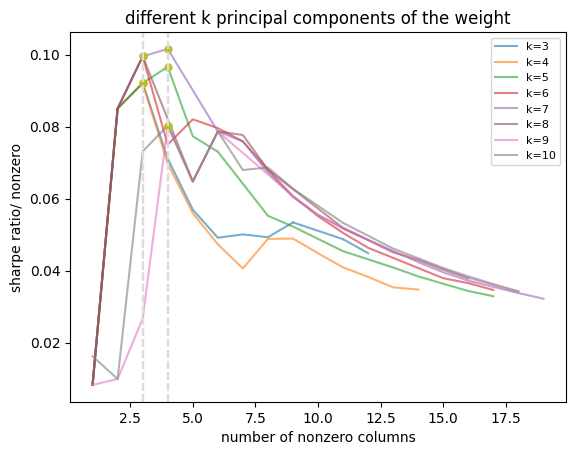

In [23]:
from helpers import *

# df99 = pd.read_csv('empirical_data/X99_22.csv')
# dff99 = df99[df99.columns[1:]]

# Z = dff99.values


df100 = pd.read_csv('empirical_data/X100_22.csv')
dff100 = df100[df100.columns[1:]]

Z = dff100.values
# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)
n, p = Z.shape

# k = 8
thousand =1
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty
PAR = [1]
# Lambd2 = [60*thousand,150*thousand,180*thousand]
# K =[12,25,30,70]
Lambd2 = np.linspace(0.1*thousand, 5*thousand, 600)
K =[3,4,5,6,7,8,9,10]
ymaxpointlist=[]
maxpointlist=[]
# Define the optimization variable Gamma'
for k in K:
    srlist=[]
    nonzerolist=[]
    
    for par in PAR:
        for lambd2 in Lambd2:
            alpha_hat = np.zeros(p)
            alpha_z = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            Z_z = np.zeros_like(Z)
            for i in range(p):
                
                # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                Z_minus_i = np.delete(Z, i, axis=1) 
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
                # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
                # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
                #                      )
            
            
            Sigma = np.cov(Z - Z_hat, rowvar=False)
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)
            
            # Sigma_z =  np.cov(Z - Z_z, rowvar=False)
            # S,U=np.linalg.eig(Sigma_z)
            # #S = np.abs(S)

            # alpha_z_score = 1/ np.diagonal(Sigma_half)
            # alpha_z_score = np.abs(np.mean(Z,axis=0))/np.std(Z,axis=0)
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
            B = cp.Variable((p,k))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
            U,S,V=np.linalg.svd(Z)
            Opt_matrix1 = U[:,:k]
            # Opt_matrix1 = np.concatenate((Z, np.zeros((1,p))),axis=0)
            # Opt_matrix1 = normalize_columns(Opt_matrix1 )
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            # Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
            Opt_matrix2 = Z  
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B) , 2, axis=1)))
            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            # objective = cp.Minimize(cp.norm((Z- Z1@ B)@Sigma_half_inv, 'fro')**2 +lambd*cp.norm(e1.T@B@Sigma_half_inv, 'fro')**2+lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            # nonzero = np.count_nonzero(np.round(row_norms[1:],6))
            # chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
            nonzero = np.count_nonzero(np.round(row_norms,6))
            
            if nonzero==1:
                chosen_set = np.argsort(row_norms)[::-1][:nonzero]
                print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
                mu = np.mean(Z, axis=0)
                Sigma = np.cov(Z.T)
                wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
                srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
                nonzerolist.append(nonzero)
                
                break
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
           
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value ), 2, axis=1)))
           
            
            srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
            nonzerolist.append(nonzero)
            
            union_set = chosen_set
            check_set = np.setdiff1d(range(p),union_set)
            check_press1 =np.mean([PRESS_statistic((Z@Sigma_half_inv)[:,i],Z[:,chosen_set]) for i in check_set])
            print( check_press1)
    maxpoint= list(np.array(srlist)/np.array(nonzerolist)).index(np.max(np.array(srlist)/np.array(nonzerolist)))
    maxpointlist.append(np.array(nonzerolist)[maxpoint])
    ymaxpointlist.append(np.max(np.array(srlist)/np.array(nonzerolist)))
    plt.plot(np.array(nonzerolist),np.array(srlist)/np.array(nonzerolist),"-", markersize=5, alpha = 0.6)
Maxpointlist =[]   
Ymaxpointlist=[]
for i in range(len(maxpointlist)):
    if maxpointlist[i]>2:
        Maxpointlist.append(maxpointlist[i])
        Ymaxpointlist.append(ymaxpointlist[i])
plt.plot(Maxpointlist,Ymaxpointlist,"o", markersize=5, alpha = 0.9)
    # plt.plot(np.array(nonzerolist),np.array(srlist)/np.array(nonzerolist),"o:")
plt.title('different k principal components of the weight')
plt.xlabel('number of nonzero columns')
plt.ylabel('sharpe ratio/ nonzero') 
plt.legend(['k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8','k=9','k=10'],prop = {'size':8},loc=1)  
for i in Maxpointlist:
    plt.axvline(x=i, ymin=0, ymax=1, color='gainsboro', linestyle='--')      
plt.show()

In [5]:
from helpers import *

df99 = pd.read_csv('empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values[:36*12]


# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)
n, p = Z.shape

# k = 8
thousand =1
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty
PAR = [2]
# Lambd2 = [60*thousand,150*thousand,180*thousand]
# K =[12,25,30,70]
Lambd2 = [0.4*thousand]
K =[6]
# Define the optimization variable Gamma'
for k in K:
    for par in PAR:
        for lambd2 in Lambd2:
            alpha_hat = np.zeros(p)
            alpha_z = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            Z_z = np.zeros_like(Z)
            for i in range(p):
                
                # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                Z_minus_i = np.delete(Z, i, axis=1) 
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
                # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
                # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
                #                      )
            
            
            Sigma = np.cov(Z - Z_hat, rowvar=False)
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)
            
            # Sigma_z =  np.cov(Z - Z_z, rowvar=False)
            # S,U=np.linalg.eig(Sigma_z)
            # #S = np.abs(S)

            # alpha_z_score = 1/ np.diagonal(Sigma_half)
            # alpha_z_score = np.abs(np.mean(Z,axis=0))/np.std(Z,axis=0)
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
            B = cp.Variable((p,p))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
            Opt_matrix1 = Z
            # Opt_matrix1 = np.concatenate((Z, np.zeros((1,p))),axis=0)
            # Opt_matrix1 = normalize_columns(Opt_matrix1 )
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            # Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
            Opt_matrix2 = Z  
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B) , 2, axis=1)))
            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            # objective = cp.Minimize(cp.norm((Z- Z1@ B)@Sigma_half_inv, 'fro')**2 +lambd*cp.norm(e1.T@B@Sigma_half_inv, 'fro')**2+lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            # nonzero = np.count_nonzero(np.round(row_norms[1:],6))
            # chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
            nonzero = np.count_nonzero(np.round(row_norms,6))
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
           
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value ), 2, axis=1)))
           
        
            
            union_set = chosen_set
            check_set = np.setdiff1d(range(p),union_set)
            check_press1 =np.mean([PRESS_statistic((Z@Sigma_half_inv)[:,i],Z[:,chosen_set]) for i in check_set])
            print( check_press1)

[83 89 87 97] ['HMLM' 'REG' 'STR' 'PEAD']
0.4 2 6 sr 0.6089927467721732 4
72.19149716010281 11.646962771227406
11786.257593237691


[83 89 93 84 87 78 97 96 11 55 94 73 77  2  9 25 61 85 86] ['HMLM' 'REG' 'ROE' 'QMJ' 'STR' 'SMB' 'PEAD' 'BETA' 'dBE' 'OCP' 'IMD' 'SP'
 'MKTRF' 'ATO' 'CTO' 'Dur' 'P52W6' 'BAB' 'LIQ']
0.05 2 3 sr 0.8404617043509546 19
32.378603496219945 9.64717376339366
1227.3847447324702
[83 89 93 84 87 78 97 96 11 55 94 73 77  2  9 25 85 61] ['HMLM' 'REG' 'ROE' 'QMJ' 'STR' 'SMB' 'PEAD' 'BETA' 'dBE' 'OCP' 'IMD' 'SP'
 'MKTRF' 'ATO' 'CTO' 'Dur' 'BAB' 'P52W6']
0.054954954954954956 2 3 sr 0.8202587470095306 18
33.02639787610339 9.924490281983813
1213.519654629589
[83 89 93 84 87 78 96 97 11 55 73 94 77  2  9 25 85 61] ['HMLM' 'REG' 'ROE' 'QMJ' 'STR' 'SMB' 'BETA' 'PEAD' 'dBE' 'OCP' 'SP' 'IMD'
 'MKTRF' 'ATO' 'CTO' 'Dur' 'BAB' 'P52W6']
0.059909909909909916 2 3 sr 0.8202587470095309 18
33.69534978933876 10.121242970566021
1213.519654629589
[83 89 93 84 87 78 96 97 11 55 73 94 77  2  9 85 25] ['HMLM' 'REG' 'ROE' 'QMJ' 'STR' 'SMB' 'BETA' 'PEAD' 'dBE' 'OCP' 'SP' 'IMD'
 'MKTRF' 'ATO' 'CTO' 'BAB' 'Dur']
0.0648648648

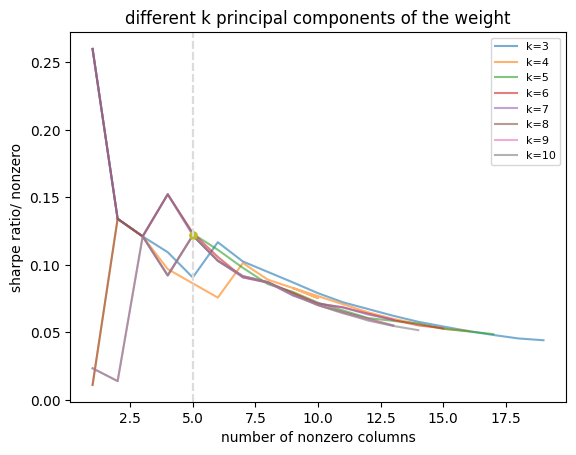

In [10]:
from helpers import *

df99 = pd.read_csv('empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values


# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)[:36*12]
n, p = Z.shape

# k = 8
thousand =1
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty
PAR = [2]
# Lambd2 = [60*thousand,150*thousand,180*thousand]
# K =[12,25,30,70]
Lambd2 = np.linspace(0.05*thousand, 5*thousand, 1000)
K =[3,4,5,6,7,8,9,10]
maxpointlist=[]
ymaxpointlist=[]
# Define the optimization variable Gamma'
for k in K:
    srlist=[]
    nonzerolist=[]
    
    for par in PAR:
        for lambd2 in Lambd2:
            alpha_hat = np.zeros(p)
            alpha_z = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            Z_z = np.zeros_like(Z)
            for i in range(p):
                
                # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                Z_minus_i = np.delete(Z, i, axis=1) 
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
                # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
                # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
                #                      )
            
            
            Sigma = np.cov(Z - Z_hat, rowvar=False)
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)
            
            # Sigma_z =  np.cov(Z - Z_z, rowvar=False)
            # S,U=np.linalg.eig(Sigma_z)
            # #S = np.abs(S)

            # alpha_z_score = 1/ np.diagonal(Sigma_half)
            # alpha_z_score = np.abs(np.mean(Z,axis=0))/np.std(Z,axis=0)
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
            B = cp.Variable((p,p))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
            Opt_matrix1 = Z
            # Opt_matrix1 = np.concatenate((Z, np.zeros((1,p))),axis=0)
            # Opt_matrix1 = normalize_columns(Opt_matrix1 )
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            # Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
            Opt_matrix2 = Z  
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B) , 2, axis=1)))
            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            # objective = cp.Minimize(cp.norm((Z- Z1@ B)@Sigma_half_inv, 'fro')**2 +lambd*cp.norm(e1.T@B@Sigma_half_inv, 'fro')**2+lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            # nonzero = np.count_nonzero(np.round(row_norms[1:],6))
            # chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
            nonzero = np.count_nonzero(np.round(row_norms,6))
            
            if nonzero==1:
                chosen_set = np.argsort(row_norms)[::-1][:nonzero]
                print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
                mu = np.mean(Z, axis=0)
                Sigma = np.cov(Z.T)
                wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
                srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
                nonzerolist.append(nonzero)
                
                break
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
           
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value ), 2, axis=1)))
           
         
            srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
            nonzerolist.append(nonzero)
            
            union_set = chosen_set
            check_set = np.setdiff1d(range(p),union_set)
            check_press1 =np.mean([PRESS_statistic((Z@Sigma_half_inv)[:,i],Z[:,chosen_set]) for i in check_set])
            print( check_press1)
    maxpoint= list(np.array(srlist)/np.array(nonzerolist)).index(np.max(np.array(srlist)/np.array(nonzerolist)))
    maxpointlist.append(np.array(nonzerolist)[maxpoint])
    ymaxpointlist.append(np.max(np.array(srlist)/np.array(nonzerolist)))
    plt.plot(np.array(nonzerolist),np.array(srlist)/np.array(nonzerolist),"-", markersize=5, alpha = 0.6)
Maxpointlist =[]   
Ymaxpointlist=[]
for i in range(len(maxpointlist)):
    if maxpointlist[i]>2:
        Maxpointlist.append(maxpointlist[i])
        Ymaxpointlist.append(ymaxpointlist[i])
        
    
plt.plot(Maxpointlist,Ymaxpointlist,"o", markersize=5, alpha = 0.9)

plt.title('different k principal components of the weight')
plt.xlabel('number of nonzero columns')
plt.ylabel('sharpe ratio/ nonzero') 
plt.legend(['k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8','k=9','k=10'],prop = {'size':8},loc=1)    
for i in Maxpointlist:
    plt.axvline(x=i, ymin=0, ymax=1, color='gainsboro', linestyle='--')      
plt.show()

In [3]:
Maxpointlist

[2, 2, 5, 5]

[84 90 85 98 79 11 97 88 94 56 78] ['HMLM' 'REG' 'QMJ' 'PEAD' 'SMB' 'dBE' 'BETA' 'STR' 'ROE' 'OCP' 'MKTRF']
0.1 -1 3 sr 0.7837563829314341 11
0.6583706046876703 0.11514264499678831
1357.3952447309684
[84 90 85 98 79 11 97 88 94 56 78] ['HMLM' 'REG' 'QMJ' 'PEAD' 'SMB' 'dBE' 'BETA' 'STR' 'ROE' 'OCP' 'MKTRF']
0.10818030050083473 -1 3 sr 0.7837563829314341 11
0.6980369043060743 0.12180451344156054
1357.3952447309684
[84 90 85 98 79 11 97 88 94 78 56] ['HMLM' 'REG' 'QMJ' 'PEAD' 'SMB' 'dBE' 'BETA' 'STR' 'ROE' 'MKTRF' 'OCP']
0.11636060100166945 -1 3 sr 0.7837563829314341 11
0.740257406320113 0.12811306232571032
1357.3952447309684
[84 90 85 98 79 11 97 88 94 78] ['HMLM' 'REG' 'QMJ' 'PEAD' 'SMB' 'dBE' 'BETA' 'STR' 'ROE' 'MKTRF']
0.12454090150250419 -1 3 sr 0.7834071457867628 10
0.7800662689278672 0.13384255037742432
1757.8716139145106
[84 90 85 98 79 11 97 88 94 78] ['HMLM' 'REG' 'QMJ' 'PEAD' 'SMB' 'dBE' 'BETA' 'STR' 'ROE' 'MKTRF']
0.13272120200333892 -1 3 sr 0.7834071457867628 10
0.82058716034

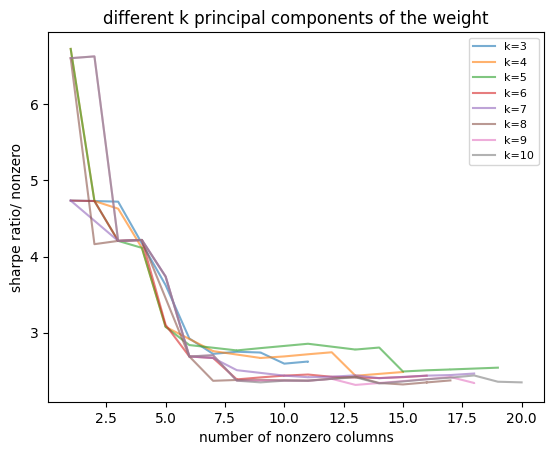

In [4]:
from helpers import *

# df99 = pd.read_csv('empirical_data/X99_22.csv')
# dff99 = df99[df99.columns[1:]]

# Z = dff99.values

df100 = pd.read_csv('empirical_data/X100_22.csv')
dff100 = df100[df100.columns[1:]]

Z = dff100.values

# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)[:36*12]
n, p = Z.shape
Lambda=0.01
# k = 8
thousand =1
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty
PAR = [-1]
# Lambd2 = [60*thousand,150*thousand,180*thousand]
# K =[12,25,30,70]
Lambd2 = np.linspace(0.1*thousand, 5*thousand, 600)
K =[3,4,5,6,7,8,9,10]

# Define the optimization variable Gamma'
maxpointlist=[]
ymaxpointlist=[]
for k in K:
    srlist=[]
    nonzerolist=[]
    grslist=[]
    for par in PAR:
        for lambd2 in Lambd2:
            alpha_hat = np.zeros(p)
            alpha_z = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            Z_z = np.zeros_like(Z)
            for i in range(p):
                
                # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                Z_minus_i = np.delete(Z, i, axis=1) 
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
                # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
                # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
                #                      )
            
            
            Sigma = np.cov(Z - Z_hat, rowvar=False)
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)
            
            # Sigma_z =  np.cov(Z - Z_z, rowvar=False)
            # S,U=np.linalg.eig(Sigma_z)
            # #S = np.abs(S)

            # alpha_z_score = 1/ np.diagonal(Sigma_half)
            # alpha_z_score = np.abs(np.mean(Z,axis=0))/np.std(Z,axis=0)
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
           
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
            B = cp.Variable((p,k))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
            U,S,V=np.linalg.svd(Z)
            Opt_matrix1 = U[:,:k]
            # Opt_matrix1 = np.concatenate((Z, np.zeros((1,p))),axis=0)
            # Opt_matrix1 = normalize_columns(Opt_matrix1 )
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            # Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
            Opt_matrix2 = Z  
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(alpha_z_score**par)@(B) , 2, axis=1)))
            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            # objective = cp.Minimize(cp.norm((Z- Z1@ B)@Sigma_half_inv, 'fro')**2 +lambd*cp.norm(e1.T@B@Sigma_half_inv, 'fro')**2+lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            # nonzero = np.count_nonzero(np.round(row_norms[1:],6))
            # chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
            nonzero = np.count_nonzero(np.round(row_norms,6))
            
            if nonzero==1:
                chosen_set = np.argsort(row_norms)[::-1][:nonzero]
                check_set = np.setdiff1d(range(p),chosen_set)
                print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
                mu = np.mean(Z, axis=0)
                Sigma = np.cov(Z.T)
                wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
                # srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
                nonzerolist.append(nonzero)
                grslist.append(GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)[1])
                break
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            check_set = np.setdiff1d(range(p),chosen_set)
            print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
            # print(lambd2,par,k,'grs',GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)[0],nonzero)
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value), 2, axis=1)))
           
            # srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
            nonzerolist.append(nonzero)  
            grslist.append(GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], Lambda)[1])
            check_press1 =np.mean([PRESS_statistic((Z@Sigma_half_inv)[:,i],Z[:,chosen_set]) for i in check_set])
            print(check_press1)
    # maxpoint= list(np.array(srlist)/np.array(nonzerolist)).index(np.max(np.array(srlist)/np.array(nonzerolist)))
    maxpoint= grslist.index(np.max(grslist))
    maxpointlist.append(np.array(nonzerolist)[maxpoint])
    # ymaxpointlist.append(np.max(np.array(srlist)/np.array(nonzerolist)))
    ymaxpointlist.append(np.max(grslist))
    plt.plot(np.array(nonzerolist),grslist,"-", markersize=5, alpha = 0.6)
    # plt.plot(np.array(nonzerolist),np.array(srlist)/np.array(nonzerolist),"-", markersize=5, alpha = 0.6)
Maxpointlist =[]    
Ymaxpointlist=[]
for i in range(len(maxpointlist)):
    if maxpointlist[i]>2:
        Maxpointlist.append(maxpointlist[i])
        Ymaxpointlist.append(ymaxpointlist[i])
plt.plot(Maxpointlist,Ymaxpointlist,"o", markersize=5, alpha = 0.9)
 

plt.title('different k principal components of the weight')
plt.xlabel('number of nonzero columns')
plt.ylabel('sharpe ratio/ nonzero') 
plt.legend(['k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8','k=9','k=10'],prop = {'size':8},loc=1)
for i in Maxpointlist:
    plt.axvline(x=i, ymin=0, ymax=1, color='gainsboro', linestyle='--')         
plt.show()

[84 90 85 98 88 79 78 97 94] ['HMLM' 'REG' 'QMJ' 'PEAD' 'STR' 'SMB' 'MKTRF' 'BETA' 'ROE']
0.05 -2 3 sr 0.7833270840802363 9
1.014774191108918 0.02473463427441884
2530.043059495569
[84 90 85 98 88 79 78] ['HMLM' 'REG' 'QMJ' 'PEAD' 'STR' 'SMB' 'MKTRF']
0.05826377295492488 -2 3 sr 0.7720786935169941 7
1.1254166036813948 0.02728308646186496
3099.2672271979704
[84 90 85 88 98 78 79] ['HMLM' 'REG' 'QMJ' 'STR' 'PEAD' 'MKTRF' 'SMB']
0.06652754590984974 -2 3 sr 0.7720786935169941 7
1.2469971023377544 0.029441814808805342
3099.2672271979695
[84 90 85 88 98 78] ['HMLM' 'REG' 'QMJ' 'STR' 'PEAD' 'MKTRF']
0.07479131886477462 -2 3 sr 0.7017954957047837 6
1.3781948740318541 0.031279794658733
3618.2986319685924
[84 90 85 88 98 78] ['HMLM' 'REG' 'QMJ' 'STR' 'PEAD' 'MKTRF']
0.0830550918196995 -2 3 sr 0.7017954957047837 6
1.4876328755730799 0.032942456140134024
3618.2986319685924
[84 90 88 85 98 78] ['HMLM' 'REG' 'STR' 'QMJ' 'PEAD' 'MKTRF']
0.09131886477462438 -2 3 sr 0.701795495704784 6
1.606666965767373

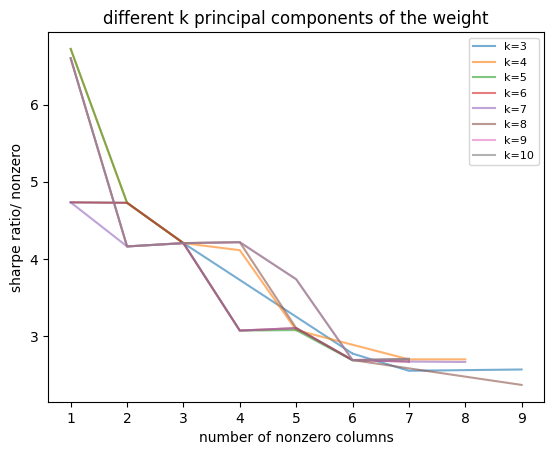

In [8]:
from helpers import *

# df99 = pd.read_csv('empirical_data/X99_22.csv')
# dff99 = df99[df99.columns[1:]]

# Z = dff99.values

df100 = pd.read_csv('empirical_data/X100_22.csv')
dff100 = df100[df100.columns[1:]]

Z = dff100.values

# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)[:36*12]
n, p = Z.shape
Lambda=0.01
# k = 8
thousand =1
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty
PAR = [-2]
# Lambd2 = [60*thousand,150*thousand,180*thousand]
# K =[12,25,30,70]
Lambd2 = np.linspace(0.05*thousand, 5*thousand, 600)
K =[3,4,5,6,7,8,9,10]

# Define the optimization variable Gamma'
maxpointlist=[]
ymaxpointlist=[]
for k in K:
    srlist=[]
    nonzerolist=[]
    grslist=[]
    for par in PAR:
        for lambd2 in Lambd2:
            alpha_hat = np.zeros(p)
            alpha_z = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            Z_z = np.zeros_like(Z)
            for i in range(p):
                
                # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                Z_minus_i = np.delete(Z, i, axis=1) 
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
                # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
                # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
                #                      )
            
            
            Sigma = np.cov(Z - Z_hat, rowvar=False)
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)
            
            # Sigma_z =  np.cov(Z - Z_z, rowvar=False)
            # S,U=np.linalg.eig(Sigma_z)
            # #S = np.abs(S)

            # alpha_z_score = 1/ np.diagonal(Sigma_half)
            # alpha_z_score = np.abs(np.mean(Z,axis=0))/np.std(Z,axis=0)
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
           
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
            B = cp.Variable((p,k))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
            U,S,V=np.linalg.svd(Z)
            Opt_matrix1 = U[:,:k]
            # Opt_matrix1 = np.concatenate((Z, np.zeros((1,p))),axis=0)
            # Opt_matrix1 = normalize_columns(Opt_matrix1 )
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            # Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
            Opt_matrix2 = Z  
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(alpha_z_score**par)@(B) , 2, axis=1)))
            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            # objective = cp.Minimize(cp.norm((Z- Z1@ B)@Sigma_half_inv, 'fro')**2 +lambd*cp.norm(e1.T@B@Sigma_half_inv, 'fro')**2+lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            # nonzero = np.count_nonzero(np.round(row_norms[1:],6))
            # chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
            nonzero = np.count_nonzero(np.round(row_norms,6))
            
            if nonzero==1:
                chosen_set = np.argsort(row_norms)[::-1][:nonzero]
                check_set = np.setdiff1d(range(p),chosen_set)
                print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
                mu = np.mean(Z, axis=0)
                Sigma = np.cov(Z.T)
                wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
                # srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
                nonzerolist.append(nonzero)
                grslist.append(GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)[1])
                break
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            check_set = np.setdiff1d(range(p),chosen_set)
            print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
            # print(lambd2,par,k,'grs',GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)[0],nonzero)
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value), 2, axis=1)))
           
            srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
            nonzerolist.append(nonzero)  
            grslist.append(GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], Lambda)[1])
            check_press1 =np.mean([PRESS_statistic((Z@Sigma_half_inv)[:,i],Z[:,chosen_set]) for i in check_set])
            print(check_press1)
    # maxpoint= list(np.array(srlist)/np.array(nonzerolist)).index(np.max(np.array(srlist)/np.array(nonzerolist)))
    maxpoint= grslist.index(np.max(grslist))
    maxpointlist.append(np.array(nonzerolist)[maxpoint])
    ymaxpointlist.append(np.max(np.array(srlist)))
    # ymaxpointlist.append(np.max(grslist))
    plt.plot(np.array(nonzerolist),grslist,"-", markersize=5, alpha = 0.6)
    # plt.plot(np.array(nonzerolist),np.array(srlist)/np.array(nonzerolist),"-", markersize=5, alpha = 0.6)
Maxpointlist =[]    
Ymaxpointlist=[]
for i in range(len(maxpointlist)):
    if maxpointlist[i]>2:
        Maxpointlist.append(maxpointlist[i])
        Ymaxpointlist.append(ymaxpointlist[i])
plt.plot(Maxpointlist,Ymaxpointlist,"o", markersize=5, alpha = 0.9)
 

plt.title('different k principal components of the weight')
plt.xlabel('number of nonzero columns')
plt.ylabel('sharpe ratio/ nonzero') 
plt.legend(['k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8','k=9','k=10'],prop = {'size':8},loc=1)
for i in Maxpointlist:
    plt.axvline(x=i, ymin=0, ymax=1, color='gainsboro', linestyle='--')         
plt.show()

In [10]:
Z[:,check_set]

array([[-0.0024316 , -0.02950966, -0.01217774, ..., -0.03601549,
         0.03293055,  0.07979382],
       [ 0.02061691, -0.00767108,  0.00227792, ..., -0.03351524,
         0.04771823,  0.04297379],
       [-0.00190611, -0.00400526, -0.028284  , ..., -0.0027979 ,
         0.03069376,  0.03179445],
       ...,
       [ 0.04205369,  0.14361943,  0.04727669, ..., -0.13947817,
         0.05442861,  0.05938383],
       [ 0.00061672,  0.08351757, -0.0099713 , ..., -0.10709399,
         0.03926813,  0.05405057],
       [-0.05578573,  0.03938582,  0.0187143 , ..., -0.03232465,
         0.03591294,  0.00092306]])

In [ ]:
chosen_set = np.argsort(row_norms[1:])[::-1][:5]

print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))

[87 83 13 97 89] ['STR' 'HMLM' 'dFIN' 'PEAD' 'REG']
100 0.9 12 sr 0.3594842851797229


In [4]:
 maxpointlist

[4]

In [117]:
row_norms = np.linalg.norm((B.value @ Sigma_half), axis=1)  # Calculate the row norms
print(np.sum(row_norms[1:]))
residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
print('RSS:', result)
print('aSa:', residual[-1]**2)
# Get the indices of the top 10 rows with largest row norms
chosen_set = np.argsort(row_norms[1:])[::-1][:6]

print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print('sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
# plt.hist(row_norms)
#50000,150000 12
# 5000 150000 9

3.500542714192768
RSS: 4143363.5452019074
aSa: 213.73257581351746
[83 84 89 87 97 94] ['HMLM' 'QMJ' 'REG' 'STR' 'PEAD' 'IMD']
sr 0.4308343384813194


In [38]:
chosen_set=[]
for i in ["MKTRF", "ME", "IA", "ROE", "REG"]:
    chosen_set.append(list(dff99.columns).index(i))
chosen_set=np.array(chosen_set)

mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set])

0.317327642613762

In [33]:
i = sr_best(Z,lambda_val = 0.06, sigma = 600, T = 10000)
np.array(dff99.columns)[i]

sr_best 0.3866338187283827


array(['MKTRF', 'HMLM', 'REG', 'PEAD'], dtype=object)

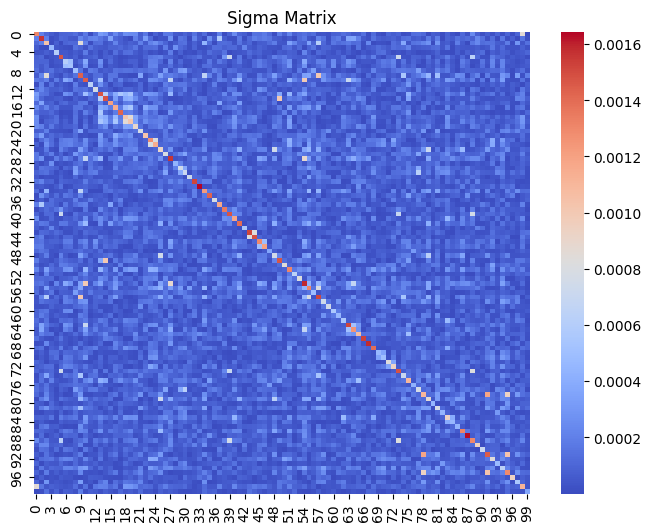

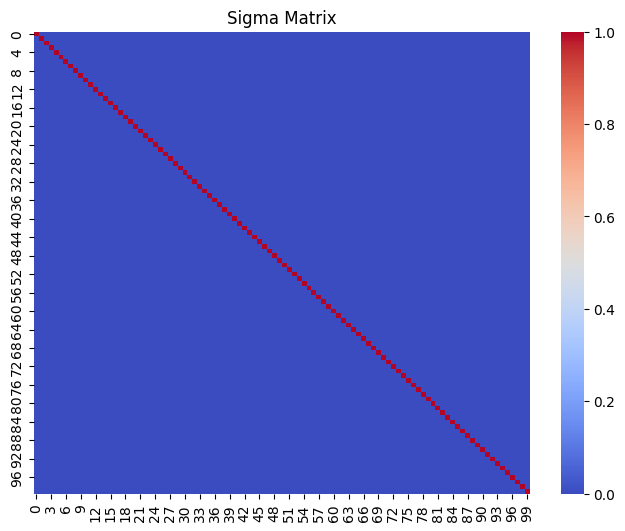

In [14]:
from helpers import *
df100 = pd.read_csv('empirical_data/X100_22.csv')
dff100 = df100[df100.columns[1:]]

fama285_ = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
test_asset = normalize_columns(fama285)

Z = dff100.values
k = 3
# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)
n, p = Z.shape
alpha_hat = np.zeros(p)
alpha_z = np.zeros(p)
Z_hat = np.zeros_like(Z)
Z_z = np.zeros_like(Z)
for i in range(p):
    
    # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
    Z_minus_i = np.delete(Z, i, axis=1) 
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
    # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
    # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
    #                      )          
Sigma = np.cov(Z - Z_hat, rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(np.abs(Sigma), cmap='coolwarm')
plt.title('Sigma Matrix')
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(np.diag(np.ones(100)), cmap='coolwarm')
plt.title('Sigma Matrix')
plt.show()

[79 84 78 91 94 90 74 11 97 86 85 56] ['SMB' 'HMLM' 'MKTRF' 'IVOL' 'ROE' 'REG' 'SP' 'dBE' 'BETA' 'BAB' 'QMJ'
 'OCP']
0.1 1 3 sr 0.596730427395271 12
0.36565331453520183 0.90407321215251
1331.180258457097
[84 79 91 78 90 94 74 11 97 86 85 56] ['HMLM' 'SMB' 'IVOL' 'MKTRF' 'REG' 'ROE' 'SP' 'dBE' 'BETA' 'BAB' 'QMJ'
 'OCP']
0.10390390390390392 1 3 sr 0.5967304273952712 12
0.38402232662246705 0.9206464744892138
1331.180258457097
[84 79 91 78 90 94 74 97 11 86 85] ['HMLM' 'SMB' 'IVOL' 'MKTRF' 'REG' 'ROE' 'SP' 'BETA' 'dBE' 'BAB' 'QMJ']
0.10780780780780781 1 3 sr 0.5961889437758852 11
0.4024725192666592 0.9364428988006511
1508.151525853798
[84 79 91 78 90 94 74 97 11 86 85] ['HMLM' 'SMB' 'IVOL' 'MKTRF' 'REG' 'ROE' 'SP' 'BETA' 'dBE' 'BAB' 'QMJ']
0.11171171171171172 1 3 sr 0.5961889437758852 11
0.42121613513310624 0.9512759370236058
1508.151525853798
[84 79 91 78 90 94 74 97 11 86 85] ['HMLM' 'SMB' 'IVOL' 'MKTRF' 'REG' 'ROE' 'SP' 'BETA' 'dBE' 'BAB' 'QMJ']
0.11561561561561562 1 3 sr 0.596188943775

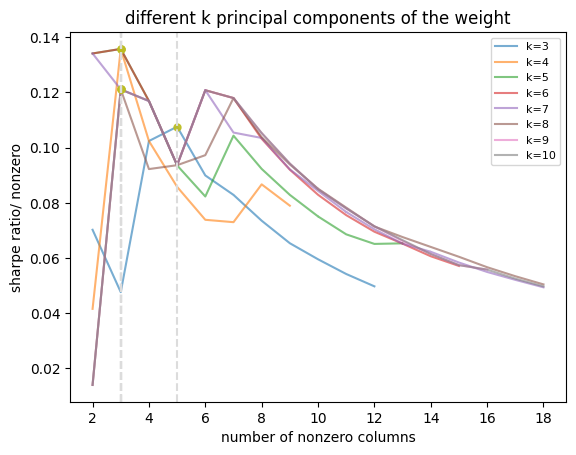

In [2]:
from helpers import *

# df99 = pd.read_csv('empirical_data/X99_22.csv')
# dff99 = df99[df99.columns[1:]]

# Z = dff99.values

df100 = pd.read_csv('empirical_data/X100_22.csv')
dff100 = df100[df100.columns[1:]]

fama285_ = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
test_asset = normalize_columns(fama285)[:36*12]

Z = dff100.values

# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)[:36*12]
n, p = Z.shape

# k = 8
thousand =1
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty
PAR = [1]
# Lambd2 = [60*thousand,150*thousand,180*thousand]
# K =[12,25,30,70]
Lambd2 = np.linspace(0.1*thousand, 4*thousand, 1000)
K =[3,4,5,6,7,8,9,10]


# Define the optimization variable Gamma'
maxpointlist=[]
ymaxpointlist=[]
for k in K:
    srlist=[]
    nonzerolist=[]
    
    for par in PAR:
        for lambd2 in Lambd2:
            alpha_hat = np.zeros(p)
            alpha_z = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            Z_z = np.zeros_like(Z)
            for i in range(p):
                
                # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                Z_minus_i = np.delete(Z, i, axis=1) 
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
                # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
                # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
                #                      )          
            Sigma = np.cov(Z - Z_hat, rowvar=False)
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)
            
            # Sigma_z =  np.cov(Z - Z_z, rowvar=False)
            # S,U=np.linalg.eig(Sigma_z)
            # #S = np.abs(S)

            # alpha_z_score = 1/ np.diagonal(Sigma_half)
            # alpha_z_score = np.abs(np.mean(Z,axis=0))/np.std(Z,axis=0)
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
            B = cp.Variable((p,k))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
             
            U,S,V=np.linalg.svd(np.concatenate((Z, test_asset), axis=1))
            Opt_matrix1 = U[:,:k]
            # Opt_matrix1 = np.concatenate((Z, np.zeros((1,p))),axis=0)
            # Opt_matrix1 = normalize_columns(Opt_matrix1 )
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            # Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
            Opt_matrix2 = Z  
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B) , 2, axis=1)))
            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            # objective = cp.Minimize(cp.norm((Z- Z1@ B)@Sigma_half_inv, 'fro')**2 +lambd*cp.norm(e1.T@B@Sigma_half_inv, 'fro')**2+lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            # nonzero = np.count_nonzero(np.round(row_norms[1:],6))
            # chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
            nonzero = np.count_nonzero(np.round(row_norms,6))
            
            if 0<nonzero<=2:
                chosen_set = np.argsort(row_norms)[::-1][:nonzero]
                print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
                mu = np.mean(Z, axis=0)
                Sigma = np.cov(Z.T)
                wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
                srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
                nonzerolist.append(nonzero)
                
                break
            if nonzero==0:
                break
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
           
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value ), 2, axis=1)))
           
            srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
            nonzerolist.append(nonzero)
            
            union_set = chosen_set
            check_set = np.setdiff1d(range(p),union_set)
            check_press1 =np.mean([PRESS_statistic((Z@Sigma_half_inv)[:,i],Z[:,chosen_set]) for i in check_set])
            print(check_press1)
    maxpoint= list(np.array(srlist)/np.array(nonzerolist)).index(np.max(np.array(srlist)/np.array(nonzerolist)))
    maxpointlist.append(np.array(nonzerolist)[maxpoint])
    ymaxpointlist.append(np.max(np.array(srlist)/np.array(nonzerolist)))
    plt.plot(np.array(nonzerolist),np.array(srlist)/np.array(nonzerolist),"-", markersize=5, alpha = 0.6)
Maxpointlist =[]   
Ymaxpointlist=[]
for i in range(len(maxpointlist)):
    if maxpointlist[i]>2:
        Maxpointlist.append(maxpointlist[i])
        Ymaxpointlist.append(ymaxpointlist[i])
plt.plot(Maxpointlist,Ymaxpointlist,"o", markersize=5, alpha = 0.9)
 

plt.title('different k principal components of the weight')
plt.xlabel('number of nonzero columns')
plt.ylabel('sharpe ratio/ nonzero') 
plt.legend(['k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8','k=9','k=10'],prop = {'size':8},loc=1)
for i in Maxpointlist:
    plt.axvline(x=i, ymin=0, ymax=1, color='gainsboro', linestyle='--')         
plt.show()

[78 84 91 79 99 81 56 90 97 62 74 86] ['MKTRF' 'HMLM' 'IVOL' 'SMB' 'FIN' 'RMW' 'OCP' 'REG' 'BETA' 'P52W6' 'SP'
 'BAB']
0.1 1 3 sr 0.41594929092159905 12
0.36549541096177623 0.8529049588077415
2297.8194291350183
[78 84 91 79 99 81 90 56 97 62 74 86] ['MKTRF' 'HMLM' 'IVOL' 'SMB' 'FIN' 'RMW' 'REG' 'OCP' 'BETA' 'P52W6' 'SP'
 'BAB']
0.10390390390390392 1 3 sr 0.4159492909215991 12
0.3814876019200477 0.8699029440355728
2297.8194291350183
[78 84 91 79 99 81 90 56 97 62 74] ['MKTRF' 'HMLM' 'IVOL' 'SMB' 'FIN' 'RMW' 'REG' 'OCP' 'BETA' 'P52W6' 'SP']
0.10780780780780781 1 3 sr 0.40794681825314166 11
0.39774660057237615 0.8860264475766999
2284.6809241353326
[78 84 91 79 81 99 90 97 56 62 74] ['MKTRF' 'HMLM' 'IVOL' 'SMB' 'RMW' 'FIN' 'REG' 'BETA' 'OCP' 'P52W6' 'SP']
0.11171171171171172 1 3 sr 0.4079468182531418 11
0.4143793881473484 0.901182215889175
2284.680924135333
[78 84 91 79 81 99 90 97 56 62 74] ['MKTRF' 'HMLM' 'IVOL' 'SMB' 'RMW' 'FIN' 'REG' 'BETA' 'OCP' 'P52W6' 'SP']
0.11561561561561562 1 3 s

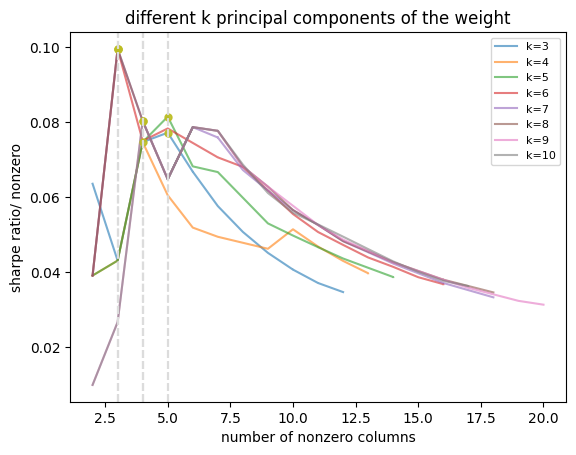

In [3]:
from helpers import *

# df99 = pd.read_csv('empirical_data/X99_22.csv')
# dff99 = df99[df99.columns[1:]]

# Z = dff99.values

df100 = pd.read_csv('empirical_data/X100_22.csv')
dff100 = df100[df100.columns[1:]]

fama285_ = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
test_asset = normalize_columns(fama285)

Z = dff100.values

# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)
n, p = Z.shape
Lambda=1
# k = 8
thousand =1
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty
PAR = [1]
# Lambd2 = [60*thousand,150*thousand,180*thousand]
# K =[12,25,30,70]
Lambd2 = np.linspace(0.1*thousand, 4*thousand, 1000)
K =[3,4,5,6,7,8,9,10]


# Define the optimization variable Gamma'
maxpointlist=[]
ymaxpointlist=[]
for k in K:
    srlist=[]
    nonzerolist=[]
    grslist=[]
    
    
    for par in PAR:
        for lambd2 in Lambd2:
            alpha_hat = np.zeros(p)
            alpha_z = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            Z_z = np.zeros_like(Z)
            for i in range(p):
                
                # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                Z_minus_i = np.delete(Z, i, axis=1) 
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
                # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
                # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
                #                      )
            
            
            Sigma = np.cov(Z - Z_hat, rowvar=False)
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)
            
            # Sigma_z =  np.cov(Z - Z_z, rowvar=False)
            # S,U=np.linalg.eig(Sigma_z)
            # #S = np.abs(S)

            # alpha_z_score = 1/ np.diagonal(Sigma_half)
            # alpha_z_score = np.abs(np.mean(Z,axis=0))/np.std(Z,axis=0)
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
            B = cp.Variable((p,k))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
             
            U,S,V=np.linalg.svd(np.concatenate((Z, test_asset), axis=1))
            Opt_matrix1 = U[:,:k]
            # Opt_matrix1 = np.concatenate((Z, np.zeros((1,p))),axis=0)
            # Opt_matrix1 = normalize_columns(Opt_matrix1 )
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            # Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
            Opt_matrix2 = Z  
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B) , 2, axis=1)))
            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            # objective = cp.Minimize(cp.norm((Z- Z1@ B)@Sigma_half_inv, 'fro')**2 +lambd*cp.norm(e1.T@B@Sigma_half_inv, 'fro')**2+lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            # nonzero = np.count_nonzero(np.round(row_norms[1:],6))
            # chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
            nonzero = np.count_nonzero(np.round(row_norms,6))
            
            if 0<nonzero<=2:
                chosen_set = np.argsort(row_norms)[::-1][:nonzero]
                print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
                mu = np.mean(Z, axis=0)
                Sigma = np.cov(Z.T)
                wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
                srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
                nonzerolist.append(nonzero)
                
                break
            if nonzero==0:
                break
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
           
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value ), 2, axis=1)))
           
            
            nonzerolist.append(nonzero)
            
            union_set = chosen_set
            
            check_set = np.setdiff1d(range(p),chosen_set)
            check_press1 =np.mean([PRESS_statistic((Z@Sigma_half_inv)[:,i],Z[:,chosen_set]) for i in check_set])
            grslist.append(GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)[1])
            print(check_press1)
    maxpoint= list(np.array(srlist)/np.array(nonzerolist)).index(np.max(np.array(srlist)/np.array(nonzerolist)))
    maxpointlist.append(np.array(nonzerolist)[maxpoint])
    ymaxpointlist.append(grslist)
    plt.plot(np.array(nonzerolist),np.array(srlist)/np.array(nonzerolist),"-", markersize=5, alpha = 0.6)
Maxpointlist =[]   
Ymaxpointlist=[]
for i in range(len(maxpointlist)):
    if maxpointlist[i]>2:
        Maxpointlist.append(maxpointlist[i])
        Ymaxpointlist.append(ymaxpointlist[i])
plt.plot(Maxpointlist,Ymaxpointlist,"o", markersize=5, alpha = 0.9)
 

plt.title('different k principal components of the weight')
plt.xlabel('number of nonzero columns')
plt.ylabel('sharpe ratio/ nonzero') 
plt.legend(['k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8','k=9','k=10'],prop = {'size':8},loc=1)
for i in Maxpointlist:
    plt.axvline(x=i, ymin=0, ymax=1, color='gainsboro', linestyle='--')         
plt.show()

[84 78 91 90 79 97] ['HMLM' 'MKTRF' 'IVOL' 'REG' 'SMB' 'BETA']
0.05 2 3 sr 0.40070764895618693 6
0.7773682360656984 0.8026007096727712
4771.582325787512
[84 78 91 90 79 97] ['HMLM' 'MKTRF' 'IVOL' 'REG' 'SMB' 'BETA']
0.053953953953953956 2 3 sr 0.40070764895618693 6
0.8319604624976501 0.8093959188360448
4771.582325787512
[84 78 91 90 79 97] ['HMLM' 'MKTRF' 'IVOL' 'REG' 'SMB' 'BETA']
0.05790790790790791 2 3 sr 0.40070764895618693 6
0.889953982158718 0.8086640275127266
4771.582325787512
[78 84 91 90 79 97] ['MKTRF' 'HMLM' 'IVOL' 'REG' 'SMB' 'BETA']
0.061861861861861864 2 3 sr 0.40070764895618693 6
0.9513755043766698 0.800427053515083
4771.582325787512
[78 84 91 90 79 97] ['MKTRF' 'HMLM' 'IVOL' 'REG' 'SMB' 'BETA']
0.06581581581581582 2 3 sr 0.40070764895618693 6
1.016248028158429 0.7847028201756904
4771.582325787512
[78 84 91 90 97 79] ['MKTRF' 'HMLM' 'IVOL' 'REG' 'BETA' 'SMB']
0.06976976976976977 2 3 sr 0.40070764895618693 6
1.0845899704209845 0.7615073580995074
4771.582325787512
[78 84 9

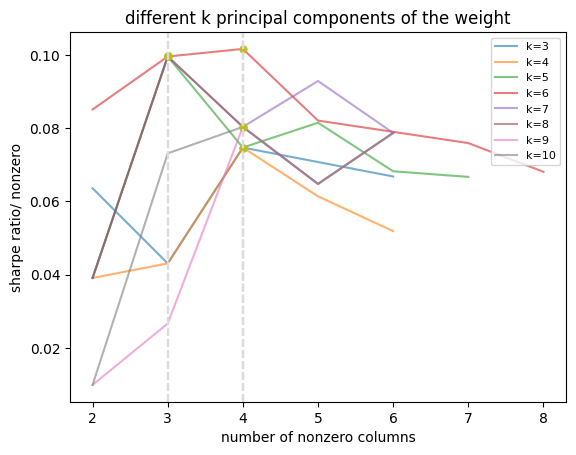

In [6]:
from helpers import *

# df99 = pd.read_csv('empirical_data/X99_22.csv')
# dff99 = df99[df99.columns[1:]]

# Z = dff99.values

df100 = pd.read_csv('empirical_data/X100_22.csv')
dff100 = df100[df100.columns[1:]]

fama285_ = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
test_asset = normalize_columns(fama285)

Z = dff100.values

# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)
n, p = Z.shape

# k = 8
thousand =1
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty
PAR = [2]
# Lambd2 = [60*thousand,150*thousand,180*thousand]
# K =[12,25,30,70]
Lambd2 = np.linspace(0.05*thousand, 4*thousand, 1000)
K =[3,4,5,6,7,8,9,10]


# Define the optimization variable Gamma'
maxpointlist=[]
ymaxpointlist=[]
for k in K:
    srlist=[]
    nonzerolist=[]
    
    for par in PAR:
        for lambd2 in Lambd2:
            alpha_hat = np.zeros(p)
            alpha_z = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            Z_z = np.zeros_like(Z)
            for i in range(p):
                
                # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                Z_minus_i = np.delete(Z, i, axis=1) 
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
                # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
                # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
                #                      )
            
            
            Sigma = np.cov(Z - Z_hat, rowvar=False)
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)
            
            # Sigma_z =  np.cov(Z - Z_z, rowvar=False)
            # S,U=np.linalg.eig(Sigma_z)
            # #S = np.abs(S)

            # alpha_z_score = 1/ np.diagonal(Sigma_half)
            # alpha_z_score = np.abs(np.mean(Z,axis=0))/np.std(Z,axis=0)
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
            B = cp.Variable((p,k))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
             
            U,S,V=np.linalg.svd(np.concatenate((Z, test_asset), axis=1))
            Opt_matrix1 = U[:,:k]
            # Opt_matrix1 = np.concatenate((Z, np.zeros((1,p))),axis=0)
            # Opt_matrix1 = normalize_columns(Opt_matrix1 )
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            # Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
            Opt_matrix2 = Z  
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B) , 2, axis=1)))
            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            # objective = cp.Minimize(cp.norm((Z- Z1@ B)@Sigma_half_inv, 'fro')**2 +lambd*cp.norm(e1.T@B@Sigma_half_inv, 'fro')**2+lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            # nonzero = np.count_nonzero(np.round(row_norms[1:],6))
            # chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
            nonzero = np.count_nonzero(np.round(row_norms,6))
            
            if 0<nonzero<=2:
                chosen_set = np.argsort(row_norms)[::-1][:nonzero]
                print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
                mu = np.mean(Z, axis=0)
                Sigma = np.cov(Z.T)
                wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
                srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
                nonzerolist.append(nonzero)
                
                break
            if nonzero==0:
                break
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
           
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value ), 2, axis=1)))
           
            srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
            nonzerolist.append(nonzero)
            
            union_set = chosen_set
            check_set = np.setdiff1d(range(p),union_set)
            check_press1 =np.mean([PRESS_statistic((Z@Sigma_half_inv)[:,i],Z[:,chosen_set]) for i in check_set])
            print(check_press1)
    maxpoint= list(np.array(srlist)/np.array(nonzerolist)).index(np.max(np.array(srlist)/np.array(nonzerolist)))
    maxpointlist.append(np.array(nonzerolist)[maxpoint])
    
    ymaxpointlist.append(np.max(np.array(srlist)/np.array(nonzerolist)))
    plt.plot(np.array(nonzerolist),np.array(srlist)/np.array(nonzerolist),"-", markersize=5, alpha = 0.6)
Maxpointlist =[]   
Ymaxpointlist=[]
for i in range(len(maxpointlist)):
    if maxpointlist[i]>2:
        Maxpointlist.append(maxpointlist[i])
        Ymaxpointlist.append(ymaxpointlist[i])
plt.plot(Maxpointlist,Ymaxpointlist,"o", markersize=5, alpha = 0.9)
 

plt.title('different k principal components of the weight')
plt.xlabel('number of nonzero columns')
plt.ylabel('sharpe ratio/ nonzero') 
plt.legend(['k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8','k=9','k=10'],prop = {'size':8},loc=1)
for i in Maxpointlist:
    plt.axvline(x=i, ymin=0, ymax=1, color='gainsboro', linestyle='--')         
plt.show()

[84 78 91 79 90 81 97 99 56 62] ['HMLM' 'MKTRF' 'IVOL' 'SMB' 'REG' 'RMW' 'BETA' 'FIN' 'OCP' 'P52W6']
0.13160740129524925 -1 3 sr 0.40656092175037695 10
0.5040541215560876 0.11516834578012788
2362.8268803438555
[84 78 91 79 90 97 81 99 62] ['HMLM' 'MKTRF' 'IVOL' 'SMB' 'REG' 'BETA' 'RMW' 'FIN' 'P52W6']
0.15655407092941873 -1 3 sr 0.4061269380334001 9
0.6245479711611485 0.13049403934587137
3239.458983560661
[84 91 78 79 90 97 81] ['HMLM' 'IVOL' 'MKTRF' 'SMB' 'REG' 'BETA' 'RMW']
0.18150074056358817 -1 3 sr 0.4032564465006677 7
0.736090146306421 0.14338467958882406
4228.175017630773
[84 78 91 79 90 97 81] ['HMLM' 'MKTRF' 'IVOL' 'SMB' 'REG' 'BETA' 'RMW']
0.20644741019775764 -1 3 sr 0.4032564465006677 7
0.8408230230201901 0.15302454279035965
4228.175017630774
[84 78 91 79 90 97 81] ['HMLM' 'MKTRF' 'IVOL' 'SMB' 'REG' 'BETA' 'RMW']
0.2313940798319271 -1 3 sr 0.4032564465006677 7
0.9567130061008283 0.16045558818241973
4228.175017630774
[84 78 91 79 90 97] ['HMLM' 'MKTRF' 'IVOL' 'SMB' 'REG' 'BETA

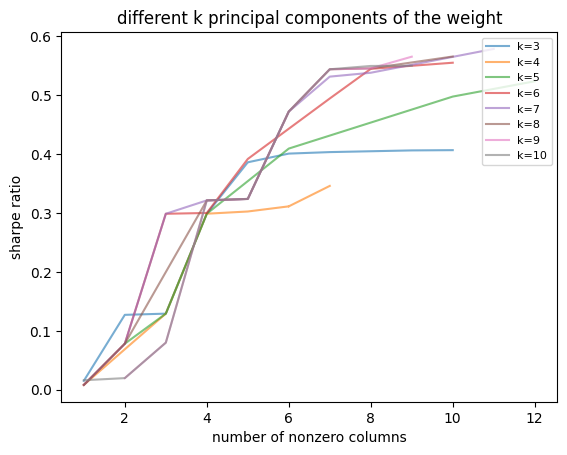

In [6]:
from helpers import *
import seaborn as sns
# df99 = pd.read_csv('empirical_data/X99_22.csv')
# dff99 = df99[df99.columns[1:]]

# Z = dff99.values

df100 = pd.read_csv('empirical_data/X100_22.csv')
dff100 = df100[df100.columns[1:]]

Z = dff100.values
fama285_ = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
test_asset = normalize_columns(fama285)
# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)
n, p = Z.shape
Lambda=0.01
# k = 8
thousand =10
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty
PAR = [-1]
# Lambd2 = [60*thousand,150*thousand,180*thousand]
# K =[12,25,30,70]

K =[3,4,5,6,7,8,9,10]
# K =[9,10,11,12,13,14]
# Define the optimization variable Gamma'
maxpointlist=[]
ymaxpointlist=[]

result1=[]
for k in K:
    Lambd2 = np.linspace(0.01*np.sqrt((np.sqrt(k)))*thousand, 5*thousand, 2000)
    srlist=[]
    nonzerolist=[]
    grslist=[]
    result0=[]
    for par in PAR:
        for lambd2 in Lambd2:
            alpha_hat = np.zeros(p)
            alpha_z = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            Z_z = np.zeros_like(Z)
            for i in range(p):
                
                # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                Z_minus_i = np.delete(Z, i, axis=1) 
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
                # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
                # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
                #                      )
            
            
            Sigma = np.cov(Z - Z_hat, rowvar=False)
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)
            
            # Sigma_z =  np.cov(Z - Z_z, rowvar=False)
            # S,U=np.linalg.eig(Sigma_z)
            # #S = np.abs(S)

            # alpha_z_score = 1/ np.diagonal(Sigma_half)
            # alpha_z_score = np.abs(np.mean(Z,axis=0))/np.std(Z,axis=0)
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
           
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
            B = cp.Variable((p,k))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
            U,S,V=np.linalg.svd(np.concatenate((Z, test_asset), axis=1))
            Opt_matrix1 = U[:,:k]
            # Opt_matrix1 = np.concatenate((Z, np.zeros((1,p))),axis=0)
            # Opt_matrix1 = normalize_columns(Opt_matrix1 )
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            # Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
            Opt_matrix2 = Z  
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(alpha_z_score**par)@(B) , 2, axis=1)))
            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            # objective = cp.Minimize(cp.norm((Z- Z1@ B)@Sigma_half_inv, 'fro')**2 +lambd*cp.norm(e1.T@B@Sigma_half_inv, 'fro')**2+lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            # nonzero = np.count_nonzero(np.round(row_norms[1:],6))
            # chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
            nonzero = np.count_nonzero(np.round(row_norms,6))
            
            if nonzero==1:
                chosen_set = np.argsort(row_norms)[::-1][:nonzero]
                check_set = np.setdiff1d(range(p),chosen_set)
                print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
                mu = np.mean(Z, axis=0)
                Sigma = np.cov(Z.T)
                wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
                srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
                nonzerolist.append(nonzero)
                # grslist.append(GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)[1])
                result0.append([nonzero,sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)[1]])
                break
            if nonzero == 0:
                break
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            check_set = np.setdiff1d(range(p),chosen_set)
            print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
            # print(lambd2,par,k,'grs',GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)[0],nonzero)
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value), 2, axis=1)))
            if not nonzerolist or (nonzero != nonzerolist[-1]):
                result0.append([nonzero,sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),GRS_test(Z[:,chosen_set], Z[:,check_set],[[False]], 1)[1]])
            srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
            nonzerolist.append(nonzero)  
            grslist.append(GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], Lambda)[1])
            
            check_press1 =np.mean([PRESS_statistic((Z@Sigma_half_inv)[:,i],Z[:,chosen_set]) for i in check_set])
            print(check_press1)
    # maxpoint= list(np.array(srlist)/np.array(nonzerolist)).index(np.max(np.array(srlist)/np.array(nonzerolist)))
    result1.append(np.array(result0))

    maxpoint= grslist.index(np.max(grslist))
    maxpointlist.append(np.array(nonzerolist)[maxpoint])
    # ymaxpointlist.append(np.max(np.array(srlist)/np.array(nonzerolist)))
    ymaxpointlist.append(np.max(grslist))
    # plt.plot(np.array(nonzerolist),grslist,"-", markersize=5, alpha = 0.6)
    plt.plot(np.array(nonzerolist),np.array(srlist),"-", markersize=5, alpha = 0.6)
# Maxpointlist =[]    
# Ymaxpointlist=[]
# for i in range(len(maxpointlist)):
#     if maxpointlist[i]>2:
#         Maxpointlist.append(maxpointlist[i])
#         Ymaxpointlist.append(ymaxpointlist[i])
# plt.plot(Maxpointlist,Ymaxpointlist,"o", markersize=5, alpha = 0.9)

plt.title('different k principal components of the weight')
plt.xlabel('number of nonzero columns')
plt.ylabel('sharpe ratio') 
plt.legend(['k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8','k=9','k=10'],prop = {'size':8},loc=1)
# for i in Maxpointlist:
#     plt.axvline(x=i, ymin=0, ymax=1, color='gainsboro', linestyle='--')         
plt.show()

In [28]:
# sns.heatmap(data=data,cmap="RdBu_r")
(result1)

[array([[4.90000000e+01, 6.04204103e-01, 3.14297000e+00],
        [4.50000000e+01, 4.64398462e-01, 4.06053237e+00],
        [4.40000000e+01, 4.57053240e-01, 4.05313733e+00],
        [4.10000000e+01, 4.39967341e-01, 3.99324752e+00],
        [4.00000000e+01, 4.39136099e-01, 3.93377477e+00],
        [3.70000000e+01, 4.22528998e-01, 3.88284312e+00],
        [3.60000000e+01, 4.19778114e-01, 3.84471639e+00],
        [3.70000000e+01, 4.31647598e-01, 3.80756207e+00],
        [3.60000000e+01, 4.19778114e-01, 3.84471639e+00],
        [3.40000000e+01, 4.16611367e-01, 3.75347916e+00],
        [3.30000000e+01, 4.11607467e-01, 3.73701783e+00],
        [3.10000000e+01, 3.91965653e-01, 3.78215499e+00],
        [3.00000000e+01, 3.90620614e-01, 3.73863886e+00],
        [2.80000000e+01, 3.66664407e-01, 3.82023072e+00],
        [2.70000000e+01, 3.66045358e-01, 3.77271019e+00],
        [2.60000000e+01, 3.66041556e-01, 3.72175678e+00],
        [2.50000000e+01, 3.61453437e-01, 3.70697527e+00],
        [2.400

[78 79 84 91 94 11 85 90 97 56 74 86 88 98] ['MKTRF' 'SMB' 'HMLM' 'IVOL' 'ROE' 'dBE' 'QMJ' 'REG' 'BETA' 'OCP' 'SP'
 'BAB' 'STR' 'PEAD']
0.01 -2 3 sr 0.8946761897310762 14
0.17183724499902123 0.005490535999160527
1310.6906681596545
[78 84 79 91 94 90 97 85 11 56 74 88 86] ['MKTRF' 'HMLM' 'SMB' 'IVOL' 'ROE' 'REG' 'BETA' 'QMJ' 'dBE' 'OCP' 'SP'
 'STR' 'BAB']
0.014994994994994995 -2 3 sr 0.6451883432190448 13
0.2418131561936453 0.008406313575471069
1333.2981424763345
[84 79 78 91 94 90 97 85 88 74 11 56] ['HMLM' 'SMB' 'MKTRF' 'IVOL' 'ROE' 'REG' 'BETA' 'QMJ' 'STR' 'SP' 'dBE'
 'OCP']
0.019989989989989992 -2 3 sr 0.6450490268317 12
0.33046369203949455 0.011488928345329743
1347.5042382751903
[84 79 91 78 90 94 97 88 85] ['HMLM' 'SMB' 'IVOL' 'MKTRF' 'REG' 'ROE' 'BETA' 'STR' 'QMJ']
0.024984984984984984 -2 3 sr 0.6375861785185142 9
0.3943706000404358 0.014223783139100133
2487.0181697279236
[84 91 79 78 90 94 97 88 85] ['HMLM' 'IVOL' 'SMB' 'MKTRF' 'REG' 'ROE' 'BETA' 'STR' 'QMJ']
0.02997997997997998

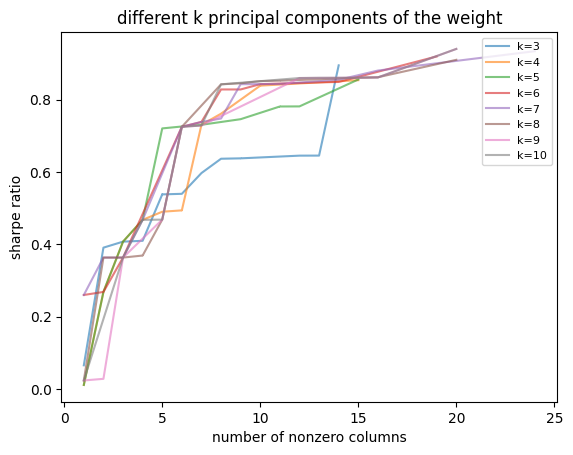

In [2]:
from helpers import *

# df99 = pd.read_csv('empirical_data/X99_22.csv')
# dff99 = df99[df99.columns[1:]]

# Z = dff99.values

df100 = pd.read_csv('empirical_data/X100_22.csv')
dff100 = df100[df100.columns[1:]]
fama285_ = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
test_asset = normalize_columns(fama285)
Z = dff100.values
test_asset=test_asset[:36*12]
# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)[:36*12]
n, p = Z.shape
Lambda=0.01
# k = 8
thousand =1
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty
PAR = [-2]
# Lambd2 = [60*thousand,150*thousand,180*thousand]
# K =[12,25,30,70]
Lambd2 = np.linspace(0.01*thousand, 5*thousand, 1000)
K =[3,4,5,6,7,8,9,10]
# K =[9,10,11,12,13,14]
# Define the optimization variable Gamma'
maxpointlist=[]
ymaxpointlist=[]
for k in K:
    srlist=[]
    nonzerolist=[]
    grslist=[]
    for par in PAR:
        for lambd2 in Lambd2:
            alpha_hat = np.zeros(p)
            alpha_z = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            Z_z = np.zeros_like(Z)
            for i in range(p):
                
                # Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                Z_minus_i = np.delete(Z, i, axis=1) 
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                # X = np.hstack((np.ones((n, 1)),Z_minus_i ))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
                # Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                # alpha_z[i]=np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0][0]
                # Z_z[:, i] = np.dot(np.hstack((np.ones((n, 1)), Ui[:,:k])), np.linalg.lstsq(np.hstack((np.ones((n, 1)), Ui[:,:k])), Z[:, i], rcond=None)[0]
                #                      )
            
            
            Sigma = np.cov(Z - Z_hat, rowvar=False)
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)
            
            # Sigma_z =  np.cov(Z - Z_z, rowvar=False)
            # S,U=np.linalg.eig(Sigma_z)
            # #S = np.abs(S)

            # alpha_z_score = 1/ np.diagonal(Sigma_half)
            # alpha_z_score = np.abs(np.mean(Z,axis=0))/np.std(Z,axis=0)
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
           
            #Gamma = cp.Variable((p+1,p))

            # B = cp.Variable((p+1,p))
            B = cp.Variable((p,k))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
            U,S,V=np.linalg.svd(np.concatenate((Z, test_asset), axis=1))
            Opt_matrix1 = U[:,:k]
            # Opt_matrix1 = np.concatenate((Z, np.zeros((1,p))),axis=0)
            # Opt_matrix1 = normalize_columns(Opt_matrix1 )
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            # Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
            Opt_matrix2 = Z  
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(alpha_z_score**par)@(B) , 2, axis=1)))
            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            # objective = cp.Minimize(cp.norm((Z- Z1@ B)@Sigma_half_inv, 'fro')**2 +lambd*cp.norm(e1.T@B@Sigma_half_inv, 'fro')**2+lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            # nonzero = np.count_nonzero(np.round(row_norms[1:],6))
            # chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
            nonzero = np.count_nonzero(np.round(row_norms,6))
            
            if nonzero==1:
                chosen_set = np.argsort(row_norms)[::-1][:nonzero]
                check_set = np.setdiff1d(range(p),chosen_set)
                print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
                mu = np.mean(Z, axis=0)
                Sigma = np.cov(Z.T)
                wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
                srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
                nonzerolist.append(nonzero)
                grslist.append(GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)[1])
                break
            if nonzero == 0:
                break
            chosen_set = np.argsort(row_norms)[::-1][:nonzero]
            check_set = np.setdiff1d(range(p),chosen_set)
            print(chosen_set,np.array(dff100.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
            # print(lambd2,par,k,'grs',GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], 1)[0],nonzero)
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Opt_matrix1 - Opt_matrix2@ B.value), 'fro')**2,
            lambd2*np.sum(np.linalg.norm(np.diag(1/alpha_z_score**par)@(B.value), 2, axis=1)))
           
            srlist.append(sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
            nonzerolist.append(nonzero)  
            grslist.append(GRS_test(Z[:,chosen_set], Z[:,check_set], [[False]], Lambda)[1])
            check_press1 =np.mean([PRESS_statistic((Z@Sigma_half_inv)[:,i],Z[:,chosen_set]) for i in check_set])
            print(check_press1)
    # maxpoint= list(np.array(srlist)/np.array(nonzerolist)).index(np.max(np.array(srlist)/np.array(nonzerolist)))
    maxpoint= grslist.index(np.max(grslist))
    maxpointlist.append(np.array(nonzerolist)[maxpoint])
    # ymaxpointlist.append(np.max(np.array(srlist)/np.array(nonzerolist)))
    ymaxpointlist.append(np.max(grslist))
    # plt.plot(np.array(nonzerolist),grslist,"-", markersize=5, alpha = 0.6)
    plt.plot(np.array(nonzerolist),np.array(srlist),"-", markersize=5, alpha = 0.6)
Maxpointlist =[]    
Ymaxpointlist=[]
for i in range(len(maxpointlist)):
    if maxpointlist[i]>2:
        Maxpointlist.append(maxpointlist[i])
        Ymaxpointlist.append(ymaxpointlist[i])
plt.plot(Maxpointlist,Ymaxpointlist,"o", markersize=5, alpha = 0.9)
 

plt.title('different k principal components of the weight')
plt.xlabel('number of nonzero columns')
plt.ylabel('sharpe ratio') 
plt.legend(['k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8','k=9','k=10'],prop = {'size':8},loc=1)
for i in Maxpointlist:
    plt.axvline(x=i, ymin=0, ymax=1, color='gainsboro', linestyle='--')         
plt.show()